<a href="https://colab.research.google.com/github/LorenzoVentrone/F1Predictor/blob/main/F1_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library installation

In [ ]:
!pip install kagglehub pandas numpy matplotlib seaborn category_encoders scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 1.8 MB/s eta 0:00:00


# Library Imports

In [ ]:
import kagglehub

import os

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, learning_curve, RandomizedSearchCV

from sklearn.preprocessing import StandardScaler, FunctionTransformer, label_binarize
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay, f1_score, roc_curve, auc, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsOneClassifier

from itertools import cycle

from scipy.special import softmax
from scipy.stats import loguniform, uniform, randint

from category_encoders import TargetEncoder

import matplotlib.pyplot as plt
import seaborn as sns


# Dataset download

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jtrotman/formula-1-race-data")

print("Path to dataset files:", path)

100%|██████████| 6.46M/6.46M [00:00<00:00, 75.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/jtrotman/formula-1-race-data/versions/107


# Dataset load

In [ ]:
import os

data_dir = path

print("Data folder:", data_dir)

Data folder: /root/.cache/kagglehub/datasets/jtrotman/formula-1-race-data/versions/107


# Preprocessing data

In [ ]:
import pandas as pd
import numpy as np

def load_csv(filename, usecols=None, nrows=None, parse_dates=None, dtype = None):
    fp = os.path.join(data_dir,filename)
    if not os.path.exists(fp):
        raise FileNotFoundError(fp)
    return pd.read_csv(fp, usecols=usecols, nrows=nrows,parse_dates=parse_dates, dtype=dtype)

#load
races = load_csv("races.csv", usecols=["raceId","year","circuitId","name","date"])
results = load_csv("results.csv",usecols=["raceId","driverId","constructorId","grid","position","points","statusId"])
drivers = load_csv("drivers.csv",usecols=["driverId","driverRef","forename","surname"])
constructors = load_csv("constructors.csv",usecols=["constructorId","constructorRef","name"])
driver_standings = load_csv("driver_standings.csv", usecols=["raceId", "driverId", "points", "position", "wins"])
constructor_standings = load_csv("constructor_standings.csv", usecols=["raceId", "constructorId", "points", "position", "wins"])
qualifying = load_csv("qualifying.csv", usecols=["raceId", "driverId", "position", "q1", "q2", "q3"])
status = load_csv("status.csv")

# Rename for clarity
qualifying = qualifying.rename(columns={
    "position": "qualifying_position"
})

constructor_standings = constructor_standings.rename(columns={
    "points": "constructor_points",
    "position": "constructor_position",
    "wins": "constructor_wins"
})
driver_standings = driver_standings.rename(columns={
    "points": "driver_points",
    "position": "driver_position",
    "wins": "driver_wins"
})


driver_standings = driver_standings.drop_duplicates(subset=["raceId", "driverId"], keep="last")
constructor_standings = constructor_standings.drop_duplicates(subset=["raceId", "constructorId"], keep="last")

# Merge driver standings into your dataset
df = results.merge(races[["raceId","year","circuitId","name","date"]], on="raceId", how="left")
df = df.merge(drivers, on="driverId", how="left")
df = df.merge(constructors, on="constructorId", how="left")
df = df.merge(driver_standings, on=["raceId", "driverId"], how="left")
df = df.merge(constructor_standings, on=["raceId", "constructorId"], how="left")
df = df.merge(qualifying[["raceId", "driverId", "qualifying_position"]], on=["raceId", "driverId"], how="left")
df = df.merge(status, on="statusId", how="left")

df = df[df["year"] >= 1980]

df["regulation_eras"] = pd.cut(
    df["year"],
    bins=[
        1979,1982,1988,1994,1999,2005,2009,2013,2016,2021,2025
    ],
    labels=[
        "Ground_Effect_1",
        "Turbo_Era",
        "Early_NA",
        "Post_Imola",
        "V10",
        "V8",
        "Hybrid_V1",
        "High_Aero",
        "Ground_Effect",
        "Post_2022"
    ],
    include_lowest=True
)

df = df.rename(columns={
    "name_x": "race_name",
    "name_y": "constructor_name",
    "driverRef": "driver",
    "constructorRef":"constructor"
})

In [ ]:
df["FinishGroup"] = pd.cut(
    pd.to_numeric(df["position"].replace("\\N", None), errors="coerce").fillna(100),
    bins=[-1, 3, 10, 100],
    labels=["Podium", "Points", "noPoints"]
)

# Create binary indicator: 1 if finished, 0 otherwise
df["did_finish"] = df["status"].apply(lambda s: 1 if s == "Finished" else 0)

# Fill NaNs
df["driver_points"] = df["driver_points"].fillna(0)
df["driver_position"] = df["driver_position"].fillna(30)  # assuming 30 = "unranked"
df["driver_wins"] = df["driver_wins"].fillna(0)

df["constructor_points"] = df["constructor_points"].fillna(0)
df["constructor_position"] = df["constructor_position"].fillna(20)  # assume 20 = unranked
df["constructor_wins"] = df["constructor_wins"].fillna(0)

df["qualifying_position"] = df["qualifying_position"].fillna(20)  # assume back-of-grid

df["driver_position"] = pd.to_numeric(df["driver_position"].replace("\\N", np.nan), errors="coerce")
df["driver_position"] = df["driver_position"].fillna(30)

## Drop data leaks and features selection

In [ ]:
df = df.drop(columns=[
    "raceId","driverId","position","points","statusId","circuitId","date",
    "forename","surname","constructor","constructorId","status",'grid'])

X_features = [
    'qualifying_position', 'year','driver','race_name', 'constructor_name',
    'driver_points', 'driver_position', 'driver_wins',
    'constructor_points', 'constructor_position',
    'constructor_wins', 'regulation_eras', 'did_finish'
]

### Data splitting

In [ ]:

df["stratify_group"] = (
    df["FinishGroup"].astype(str) + "_" + df["regulation_eras"].astype(str)
)

X = df[X_features]
y = df["FinishGroup"]



X_train, X_test, y_train, y_test, strat_train, strat_test = train_test_split(
    X, y, df["stratify_group"],
    test_size=0.20,
    random_state=42,
    stratify=df["stratify_group"]
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=0.20,
    random_state=42,
    stratify=strat_train
)

#Define cross-validation method for all models

cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

print("Train shape:", X_train.shape)
print("Val shape:",   X_val.shape)
print("Test shape:",  X_test.shape)

Train shape: (12320, 13)
Val shape: (3080, 13)
Test shape: (3851, 13)


## Normalization and Encoding processes

In [ ]:
# Feature selection
numerical_features = [
    'year','driver_points',
    'driver_position', 'driver_wins',
    'constructor_points', 'constructor_position',
    'constructor_wins', 'qualifying_position'
]

categorical_features = [
    'constructor_name', 'race_name', 'regulation_eras', 'did_finish', 'driver'
]

# Define the transformers
numeric_transformer = StandardScaler()
categorical_transformer = TargetEncoder()

# ColumnTransformer with both
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Fit on training data only
X_train_processed = preprocessor.fit_transform(X_train, y_train)

# Transform validation/test
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)

print(X_train_processed.shape)

(12320, 13)


# Exploring Data Analysis

Dataset shape: (19251, 15)


,year,race_name,driver,constructor_name,driver_points,driver_position,driver_wins,constructor_points,constructor_position,constructor_wins,qualifying_position,regulation_eras,FinishGroup,did_finish,stratify_group
0,2008,Australian Grand Prix,hamilton,McLaren,10.0,1.0,1.0,14.0,1.0,1.0,1.0,V8,Podium,1,Podium_V8
1,2008,Australian Grand Prix,heidfeld,BMW Sauber,8.0,2.0,0.0,8.0,3.0,0.0,5.0,V8,Podium,1,Podium_V8
2,2008,Australian Grand Prix,rosberg,Williams,6.0,3.0,0.0,9.0,2.0,0.0,7.0,V8,Podium,1,Podium_V8
3,2008,Australian Grand Prix,alonso,Renault,5.0,4.0,0.0,5.0,4.0,0.0,12.0,V8,Points,1,Points_V8
4,2008,Australian Grand Prix,kovalainen,McLaren,4.0,5.0,0.0,14.0,1.0,1.0,3.0,V8,Points,1,Points_V8


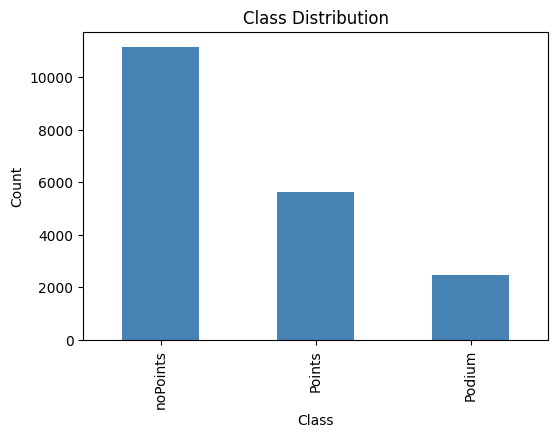


Class distribution (numeric):
FinishGroup
noPoints    0.580178
Points      0.292400
Podium      0.127422
Name: proportion, dtype: float64


,count,mean,std,min,25%,50%,75%,max
year,19251.0,2002.185445,13.532998,1980.0,1990.0,2002.0,2014.0,2025.0
driver_points,19251.0,25.046283,51.684441,0.0,0.0,5.0,24.0,575.0
driver_position,19251.0,13.391876,8.489210,1.0,6.0,13.0,19.0,47.0
driver_wins,19251.0,0.401901,1.295537,0.0,0.0,0.0,0.0,19.0
constructor_points,19251.0,50.518674,99.755742,0.0,1.0,11.0,51.0,860.0
constructor_position,19251.0,6.762246,4.124597,1.0,3.0,6.0,9.0,20.0
constructor_wins,19251.0,0.811542,2.130524,0.0,0.0,0.0,0.0,21.0
qualifying_position,19251.0,14.993039,6.422368,1.0,10.0,19.0,20.0,28.0
did_finish,19251.0,0.336034,0.472363,0.0,0.0,0.0,1.0,1.0


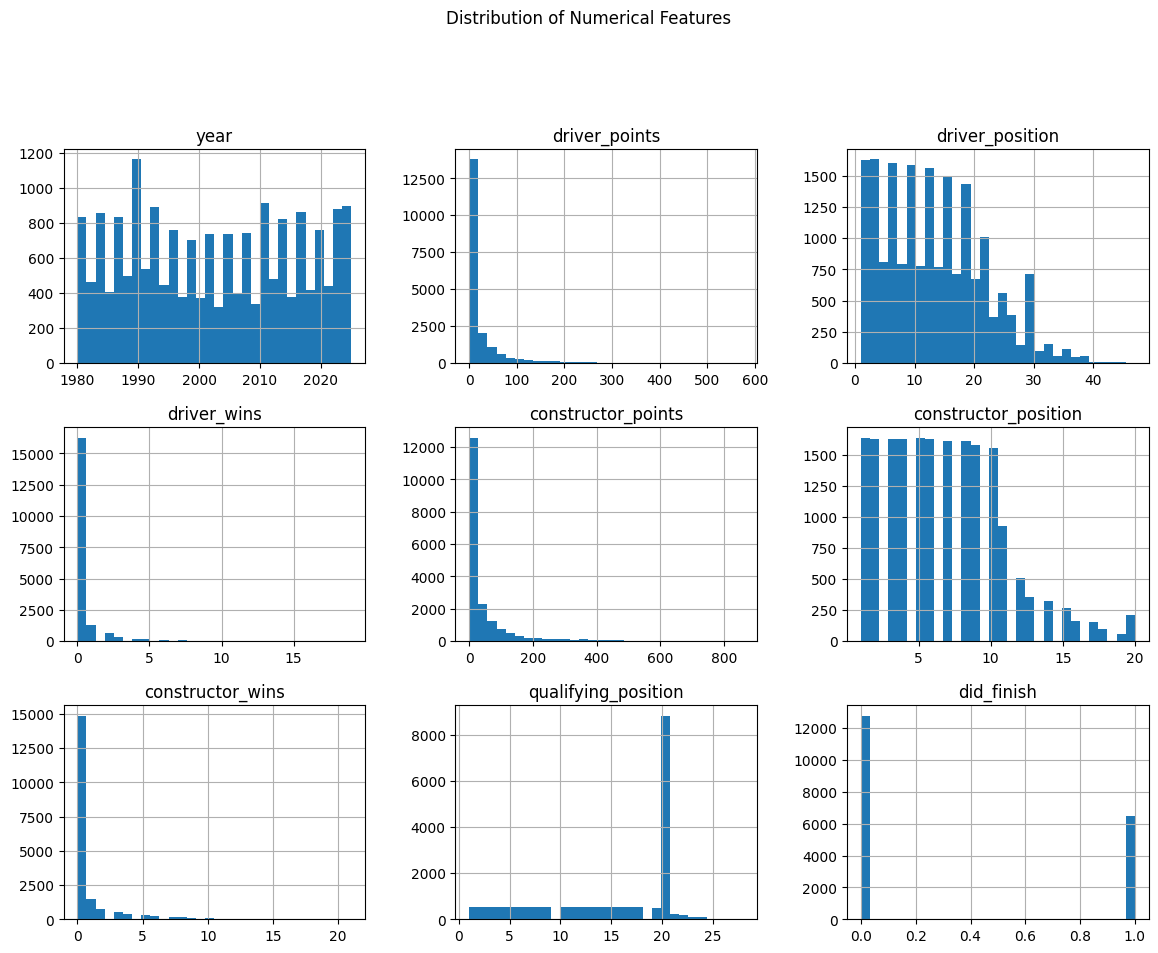


Categorical feature cardinality:
race_name: 50 unique values
driver: 288 unique values
constructor_name: 71 unique values
regulation_eras: 10 unique values
FinishGroup: 3 unique values
stratify_group: 30 unique values


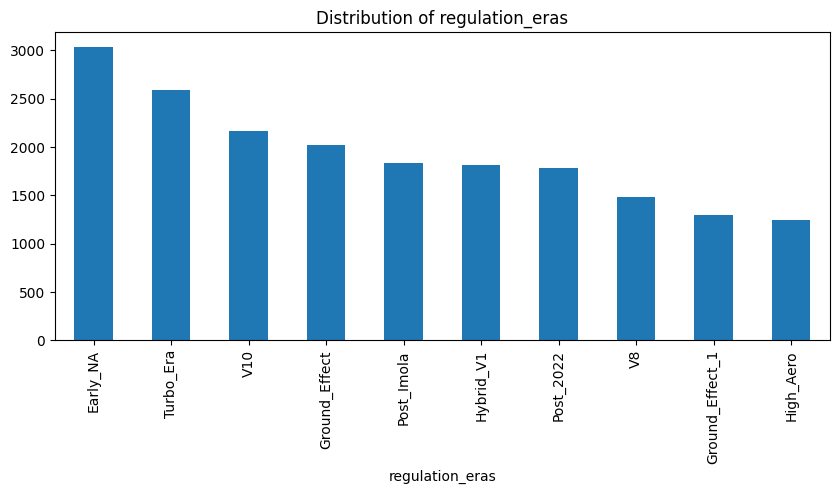

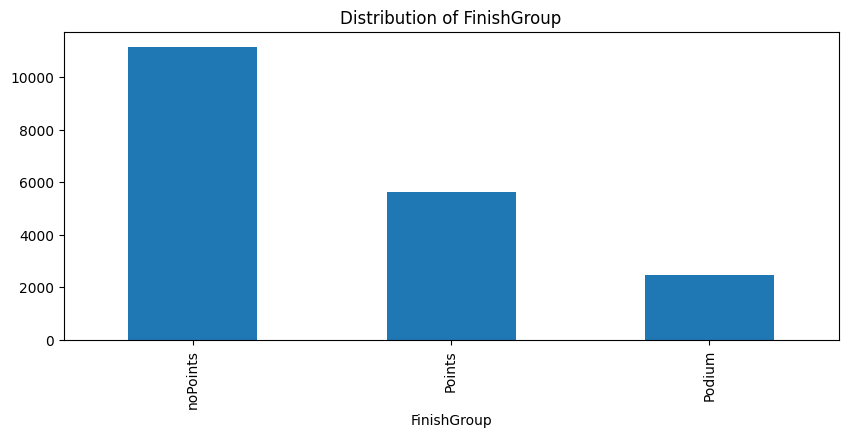

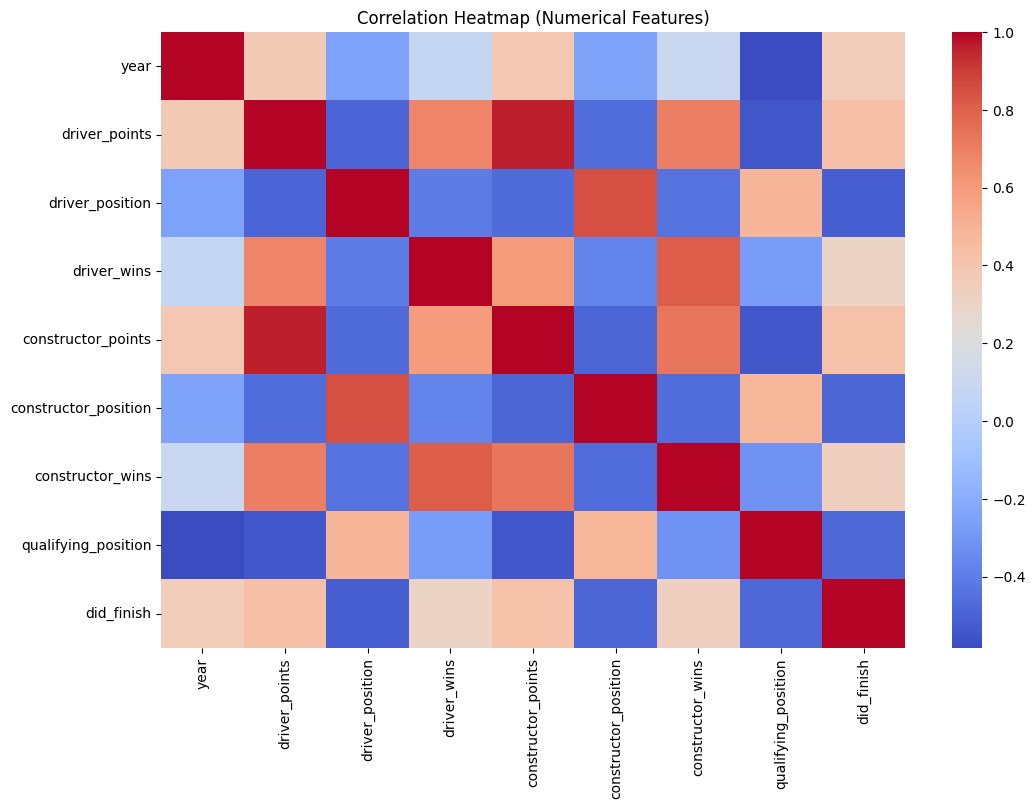


Strong correlations (|corr| > 0.6):


,driver_points,driver_position,driver_wins,constructor_points,constructor_position,constructor_wins
driver_points,NaN,NaN,0.681508,0.959814,NaN,0.697781
driver_position,NaN,NaN,NaN,NaN,0.846905,NaN
driver_wins,0.681508,NaN,NaN,NaN,NaN,0.814218
constructor_points,0.959814,NaN,NaN,NaN,NaN,0.728223
constructor_position,NaN,0.846905,NaN,NaN,NaN,NaN
constructor_wins,0.697781,NaN,0.814218,0.728223,NaN,NaN


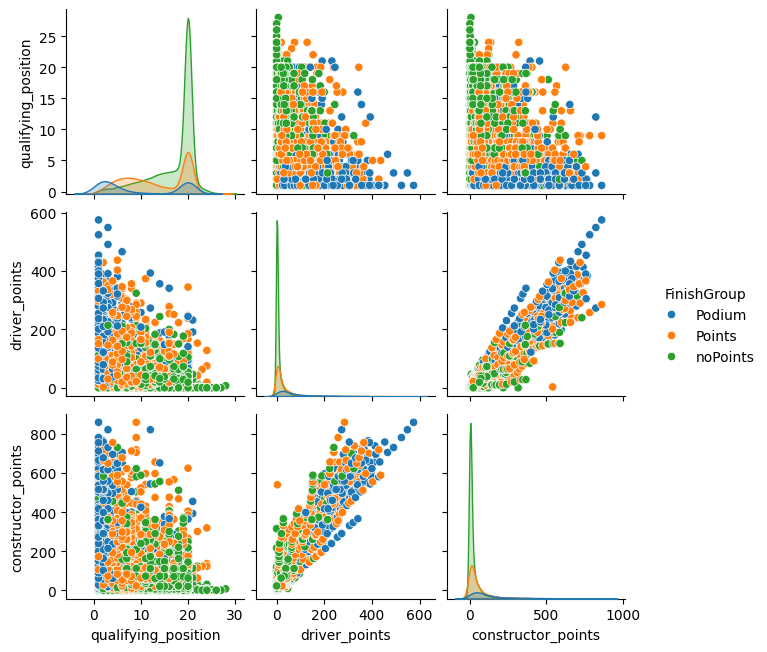

In [ ]:
#Basic Dataset Overview
print("Dataset shape:", df.shape)
display(df.head())

#Class Distribution
plt.figure(figsize=(6,4))
df['FinishGroup'].value_counts().plot(kind='bar', color='steelblue')
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

print("\nClass distribution (numeric):")
print(df['FinishGroup'].value_counts(normalize=True))


#Summary Statistics for Numerical Features
numeric_cols = df.select_dtypes(include=['int64','float64']).columns
display(df[numeric_cols].describe().T)

# Histograms of numerical features
df[numeric_cols].hist(figsize=(14,10), bins=30)
plt.suptitle("Distribution of Numerical Features", y=1.02)
plt.show()

#Categorical Features Overview
categorical_cols = df.select_dtypes(include=['object','category']).columns
print("\nCategorical feature cardinality:")
for col in categorical_cols:
    print(f"{col}: {df[col].nunique()} unique values")

# Bar plots for categorical variables (only if low cardinality)
for col in categorical_cols:
    if df[col].nunique() <= 20:
        plt.figure(figsize=(10,4))
        df[col].value_counts().plot(kind='bar')
        plt.title(f"Distribution of {col}")
        plt.show()

#Correlation Matrix
plt.figure(figsize=(12,8))
corr = df[numeric_cols].corr()
sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.title("Correlation Heatmap (Numerical Features)")
plt.show()

# Highlight strong correlations
threshold = 0.6
strong_corr = corr[((corr >= threshold) | (corr <= -threshold)) & (corr != 1)]
print("\nStrong correlations (|corr| > 0.6):")
display(strong_corr.dropna(how='all').dropna(axis=1, how='all'))

#Pairplot for Key Variables
important_vars = ['qualifying_position', 'driver_points', 'constructor_points', 'FinishGroup']
subset = df[important_vars].copy()
sns.pairplot(subset, hue='FinishGroup', diag_kind='kde', height=2.2)
plt.show()


# Learning Curve function

In [ ]:
def plot_learning_curve(estimator, X, y, cv, scoring, model_name="Model", train_sizes=np.linspace(0.1, 1.0, 6)):
    print(f"Plotting learning curve for {model_name}...")

    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y,
        train_sizes=train_sizes,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        shuffle=True,
        random_state=42
    )

    train_mean = train_scores.mean(axis=1)
    val_mean = val_scores.mean(axis=1)

    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_mean, 'o-', label='Training score')
    plt.plot(train_sizes, val_mean, 'o-', label='Validation score')
    plt.fill_between(train_sizes, train_scores.min(axis=1), train_scores.max(axis=1), alpha=0.1)
    plt.fill_between(train_sizes, val_scores.min(axis=1), val_scores.max(axis=1), alpha=0.1)

    plt.title(f"Learning Curve: {model_name}")
    plt.xlabel("Training Set Size")
    plt.ylabel(scoring.capitalize())
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Gaussian NB


In [ ]:
from sklearn.naive_bayes import GaussianNB

model_NB = GaussianNB()

x_train_dense = X_train_processed
x_val_dense = X_val_processed
x_test_dense = X_test_processed

print("GNB training start\n")

model_NB.fit(x_train_dense, y_train)

print("Training completed")

GNB training start

Training completed


### GNB results

--- Naïve Bayes Validation Results ---
Accuracy: 0.7078

Classification Report:
              precision    recall  f1-score   support

      Podium       0.62      0.72      0.67       393
      Points       0.52      0.43      0.47       901
    noPoints       0.81      0.85      0.83      1786

    accuracy                           0.71      3080
   macro avg       0.65      0.66      0.65      3080
weighted avg       0.70      0.71      0.70      3080

Plotting confusion matrix...


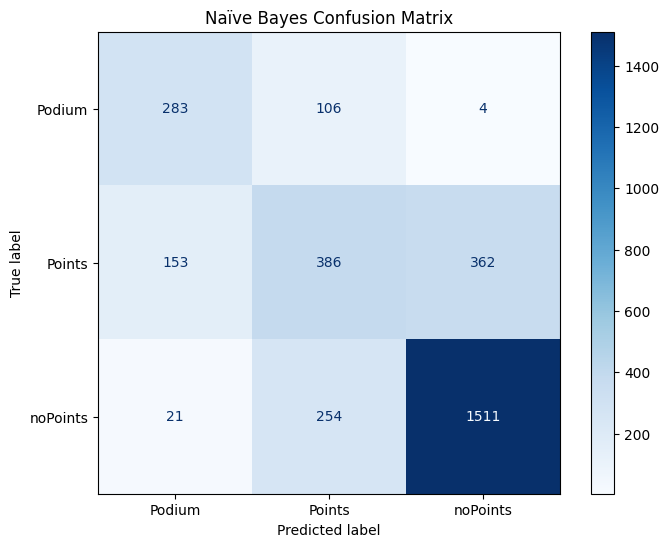

Plotting learning curve for GNB...


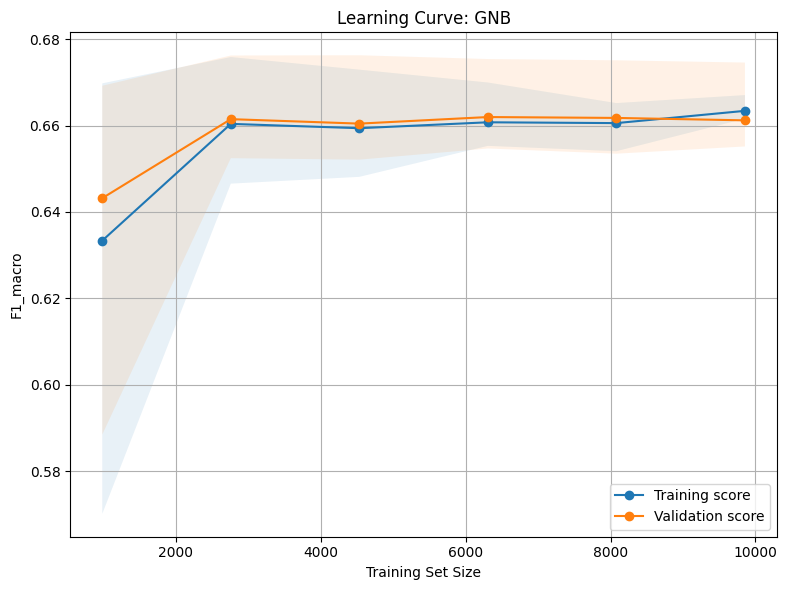

In [ ]:
# Evaluation

y_pred_nb_val = model_NB.predict(x_val_dense)

#Print the Classification Report
print("--- Naïve Bayes Validation Results ---")
print(f"Accuracy: {accuracy_score(y_val, y_pred_nb_val):.4f}")
print("\nClassification Report:")
# use the actual category names present in y_val ('noPoint' is the correct label)
print(classification_report(y_val, y_pred_nb_val, labels=['Podium', 'Points', 'noPoints'],zero_division=0))

#Plot the Confusion Matrix
print("Plotting confusion matrix...")
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_estimator(
    model_NB,
    x_val_dense,
    y_val,
    labels=['Podium', 'Points', 'noPoints'],
    cmap='Blues',
    ax=ax
)
ax.set_title("Naïve Bayes Confusion Matrix")
plt.show()

plot_learning_curve(
    estimator=model_NB,
    X=X_train_processed, y=y_train,
    cv=cv,
    scoring='f1_macro',
    model_name="GNB"
)

# Softmax regression with RandomizedSearchCV

In [ ]:
#Define the model
model_lr_random = LogisticRegression(
    solver='lbfgs',
    max_iter=5000,
    random_state=42
)

#Define parameter distributions for RandomizedSearch
param_dist_lr = {
    'C': loguniform(0.1, 50),  # logarithmic scale from 0.01 to 50
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Run RandomizedSearchCV
print("Running RandomizedSearchCV for Softmax Regression...")
random_search_lr = RandomizedSearchCV(
    estimator=model_lr_random,
    param_distributions=param_dist_lr,
    n_iter=50,
    cv=cv,
    scoring='f1_macro',
    verbose=2,
    n_jobs=-1,
    #random_state=42
)

# Train
random_search_lr.fit(X_train_processed, y_train)

# Best model
best_model_lr_random = random_search_lr.best_estimator_
print("\n" + "="*60)
print("RandomizedSearchCV completed!")
print("="*60)
print(f"Best Softmax hyperparameters: {random_search_lr.best_params_}")
print(f"Best CV F1-macro score: {random_search_lr.best_score_:.4f}")



Running RandomizedSearchCV for Softmax Regression...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

RandomizedSearchCV completed!
Best Softmax hyperparameters: {'C': np.float64(1.1376963346278794)}
Best CV F1-macro score: 0.7260



SOFTMAX REGRESSION (RandomizedSearchCV) - VALIDATION RESULTS
Accuracy: 0.7675
F1-macro: 0.7171

Classification Report:
              precision    recall  f1-score   support

      Podium       0.75      0.72      0.73       393
      Points       0.64      0.49      0.56       901
    noPoints       0.82      0.92      0.86      1786

    accuracy                           0.77      3080
   macro avg       0.73      0.71      0.72      3080
weighted avg       0.76      0.77      0.76      3080

Plotting confusion matrix...


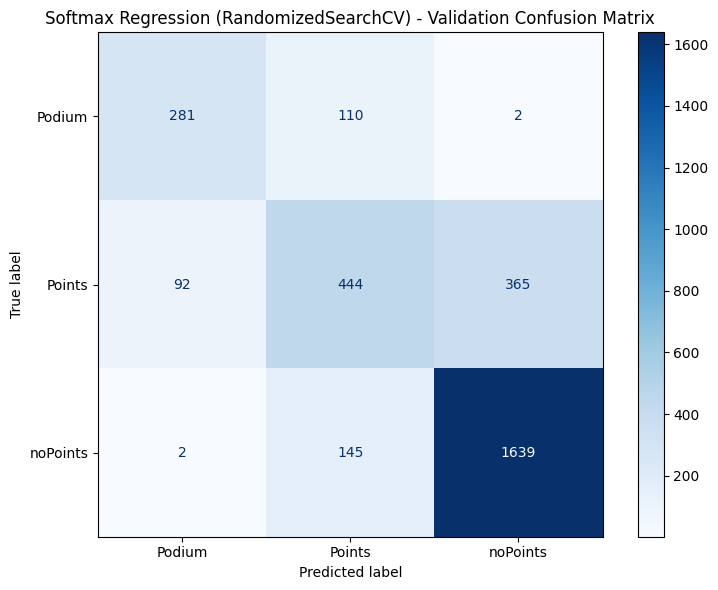

Plotting learning curve for Softmax Regression (RandomizedSearchCV)...


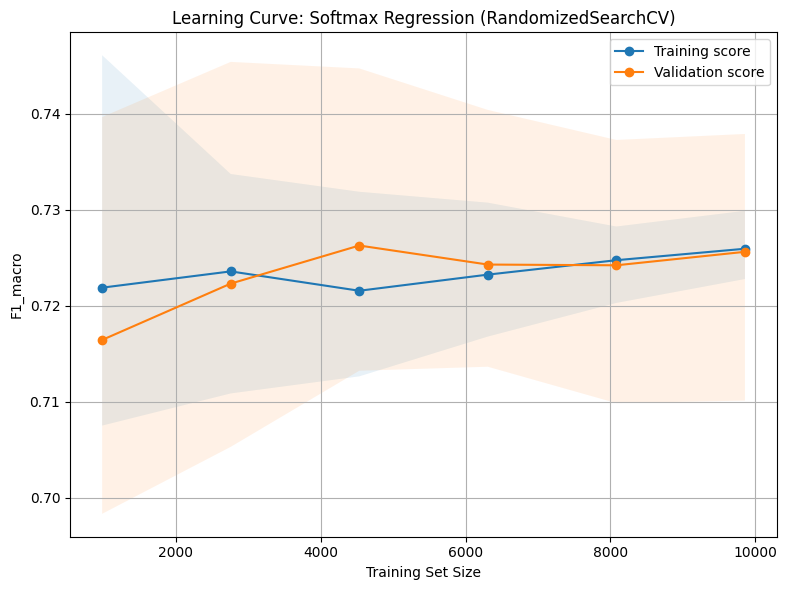

In [ ]:
# VALIDATION SET EVALUATION
from sklearn.metrics import f1_score
# Predict on validation set
y_val_pred_lr_random = best_model_lr_random.predict(X_val_processed)

# Print Classification Report
print("\n" + "="*60)
print("SOFTMAX REGRESSION (RandomizedSearchCV) - VALIDATION RESULTS")
print("="*60)
print(f"Accuracy: {accuracy_score(y_val, y_val_pred_lr_random):.4f}")
print(f"F1-macro: {f1_score(y_val, y_val_pred_lr_random, labels=['Podium', 'Points', 'noPoints'], average='macro'):.4f}\n")
print("Classification Report:")
print(classification_report(y_val, y_val_pred_lr_random, labels=['Podium', 'Points', 'noPoints']))

# Plot Confusion Matrix
print("Plotting confusion matrix...")
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_estimator(
    best_model_lr_random,
    X_val_processed,
    y_val,
    labels=['Podium', 'Points', 'noPoints'],
    cmap='Blues',
    ax=ax
)
ax.set_title("Softmax Regression (RandomizedSearchCV) - Validation Confusion Matrix")
plt.tight_layout()
plt.show()

# Learning Curve
plot_learning_curve(
    estimator=best_model_lr_random,
    X=X_train_processed,
    y=y_train,
    cv=cv,
    scoring='f1_macro',
    model_name="Softmax Regression (RandomizedSearchCV)"
)

# Decision tree with RandomizedSearchCV

In [ ]:
# Initialize base model
dt_model_random = DecisionTreeClassifier(random_state=42)

# Define parameter distributions
param_dist_dt = {
    'max_depth': randint(5, 50),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': uniform(0.3, 0.7),
    'class_weight': ['balanced', None]
}

# Run RandomizedSearchCV
print("Running RandomizedSearchCV for Decision Tree...")
random_search_dt = RandomizedSearchCV(
    dt_model_random,
    param_distributions=param_dist_dt,
    n_iter=50,  # 50 random combinations
    cv=cv,
    scoring='f1_macro',
    n_jobs=-1,
    random_state=42,
    verbose=2
)

random_search_dt.fit(X_train_processed, y_train)

# Get best model
best_model_dt_random = random_search_dt.best_estimator_
print("\n" + "="*60)
print("RandomizedSearchCV completed!")
print("="*60)
print(f"Best hyperparameters: {random_search_dt.best_params_}")
print(f"Best CV F1-macro score: {random_search_dt.best_score_:.4f}")



Running RandomizedSearchCV for Decision Tree...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

RandomizedSearchCV completed!
Best hyperparameters: {'class_weight': None, 'max_depth': 6, 'max_features': np.float64(0.7789631185585097), 'min_samples_leaf': 7, 'min_samples_split': 13}
Best CV F1-macro score: 0.7323



DECISION TREE (RandomizedSearchCV) - VALIDATION RESULTS
Accuracy: 0.7870
F1-macro: 0.7316

Classification Report:
              precision    recall  f1-score   support

      Podium       0.78      0.75      0.76       393
      Points       0.72      0.45      0.56       901
    noPoints       0.81      0.97      0.88      1786

    accuracy                           0.79      3080
   macro avg       0.77      0.72      0.73      3080
weighted avg       0.78      0.79      0.77      3080

Plotting confusion matrix...


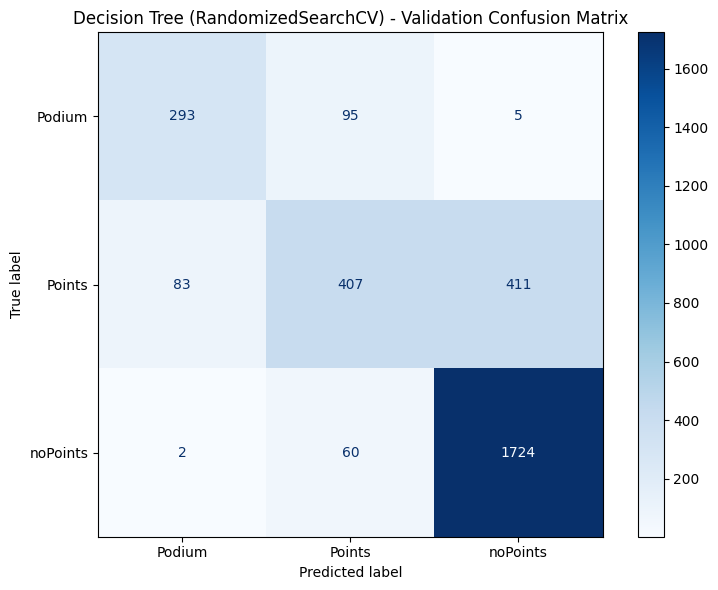

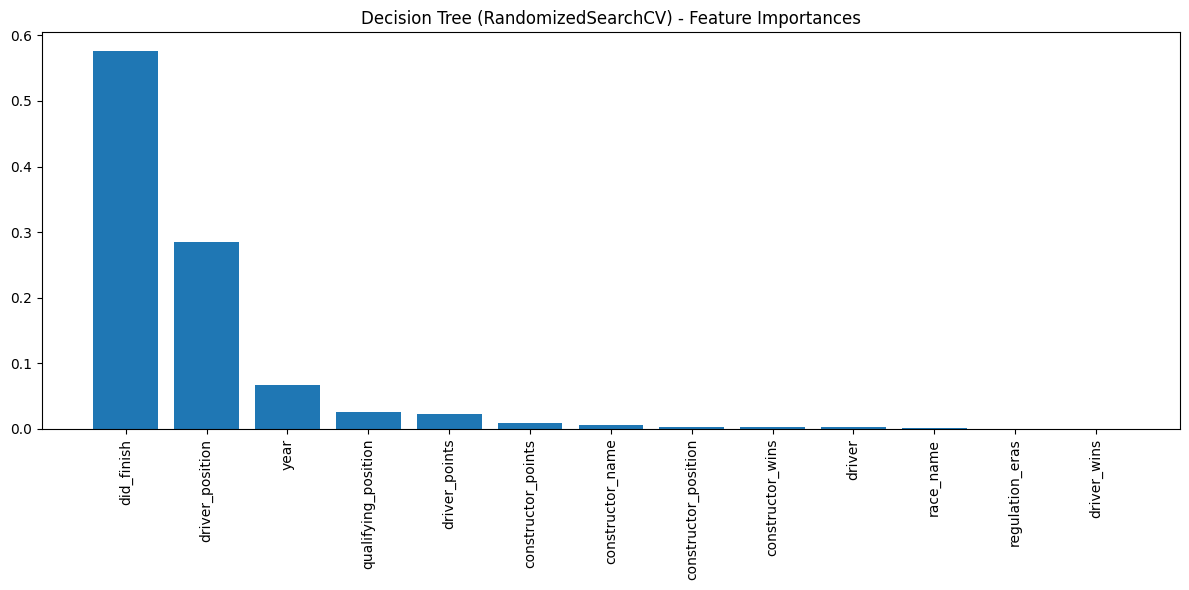

Plotting learning curve for Decision Tree (RandomizedSearchCV)...


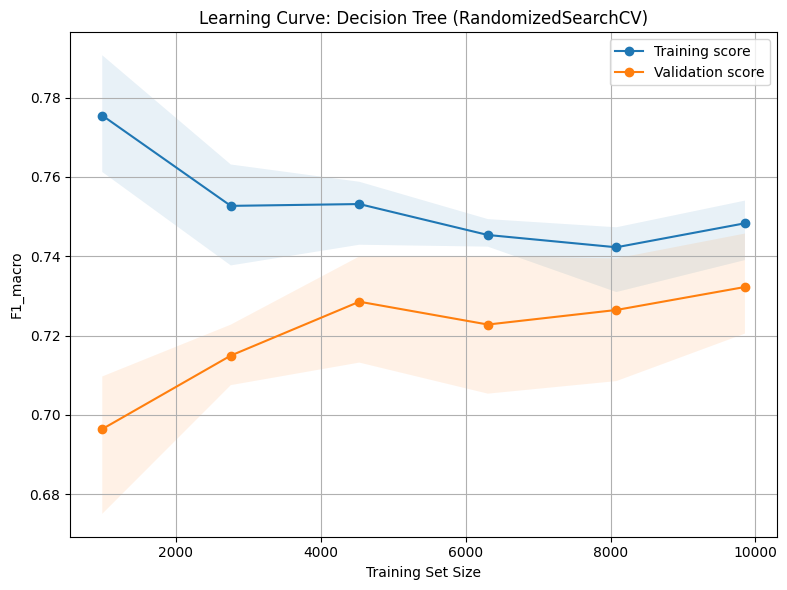

In [ ]:
# ============================================
# VALIDATION SET EVALUATION
# ============================================

# 1. Get predictions on validation set
y_val_pred_dt_random = best_model_dt_random.predict(X_val_processed)

# 2. Print Classification Report
print("\n" + "="*60)
print("DECISION TREE (RandomizedSearchCV) - VALIDATION RESULTS")
print("="*60)
print(f"Accuracy: {accuracy_score(y_val, y_val_pred_dt_random):.4f}")
print(f"F1-macro: {f1_score(y_val, y_val_pred_dt_random, labels=['Podium', 'Points', 'noPoints'], average='macro'):.4f}\n")
print("Classification Report:")
print(classification_report(y_val, y_val_pred_dt_random, labels=['Podium', 'Points', 'noPoints']))

# 3. Plot Confusion Matrix
print("Plotting confusion matrix...")
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_estimator(
    best_model_dt_random,
    X_val_processed,
    y_val,
    labels=['Podium', 'Points', 'noPoints'],
    cmap='Blues',
    ax=ax
)
ax.set_title("Decision Tree (RandomizedSearchCV) - Validation Confusion Matrix")
plt.tight_layout()
plt.show()

# 4. Feature Importances
feature_names_num = numerical_features
feature_names_cat = list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))
all_feature_names = feature_names_num + feature_names_cat

importances_dt_random = best_model_dt_random.feature_importances_
indices_dt_random = np.argsort(importances_dt_random)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Decision Tree (RandomizedSearchCV) - Feature Importances")
plt.bar(range(len(importances_dt_random)), importances_dt_random[indices_dt_random])
plt.xticks(range(len(importances_dt_random)), [all_feature_names[i] for i in indices_dt_random], rotation=90)
plt.tight_layout()
plt.show()

# 5. Learning Curve
plot_learning_curve(
    estimator=best_model_dt_random,
    X=X_train_processed,
    y=y_train,
    cv=cv,
    scoring='f1_macro',
    model_name="Decision Tree (RandomizedSearchCV)"
)


# Radom Forest with RandomizedSearchCV

In [ ]:
#Initialize base model
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)

# Define parameter distributions
param_dist_rf = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(15, 30),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': uniform(0.3, 0.7),
    'class_weight': ['balanced', None]
}

# Run RandomizedSearchCV
print("Running RandomizedSearchCV for Random Forest...")
random_search_rf = RandomizedSearchCV(
    rf_model,
    param_distributions=param_dist_rf,
    n_iter=10,  # 50 random combinations
    cv=cv,
    scoring='f1_macro',
    n_jobs=-1,
    random_state=42,
    verbose=2
)

random_search_rf.fit(X_train_processed, y_train)

# Get best model
best_model_rf_random = random_search_rf.best_estimator_
print("\n" + "="*60)
print("RandomizedSearchCV completed!")
print("="*60)
print(f"Best hyperparameters: {random_search_rf.best_params_}")
print(f"Best CV F1-macro score: {random_search_rf.best_score_:.4f}")



Running RandomizedSearchCV for Random Forest...
Fitting 5 folds for each of 10 candidates, totalling 50 fits

RandomizedSearchCV completed!
Best hyperparameters: {'class_weight': None, 'max_depth': 26, 'max_features': np.float64(0.4283831568974037), 'min_samples_leaf': 6, 'min_samples_split': 13, 'n_estimators': 444}
Best CV F1-macro score: 0.7491



RANDOM FOREST (RandomizedSearchCV) - VALIDATION RESULTS
Accuracy: 0.7955
F1-macro: 0.7483

Classification Report:
              precision    recall  f1-score   support

      Podium       0.80      0.74      0.77       393
      Points       0.72      0.51      0.60       901
    noPoints       0.82      0.95      0.88      1786

    accuracy                           0.80      3080
   macro avg       0.78      0.73      0.75      3080
weighted avg       0.79      0.80      0.78      3080

Plotting confusion matrix...


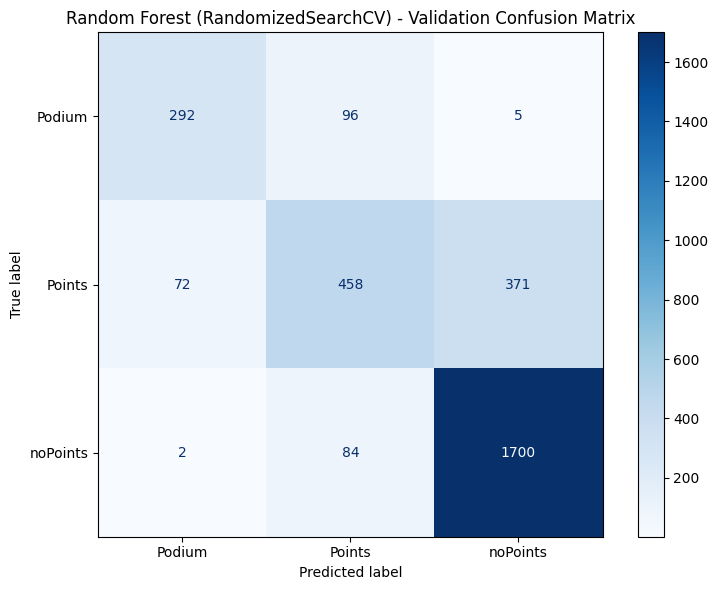

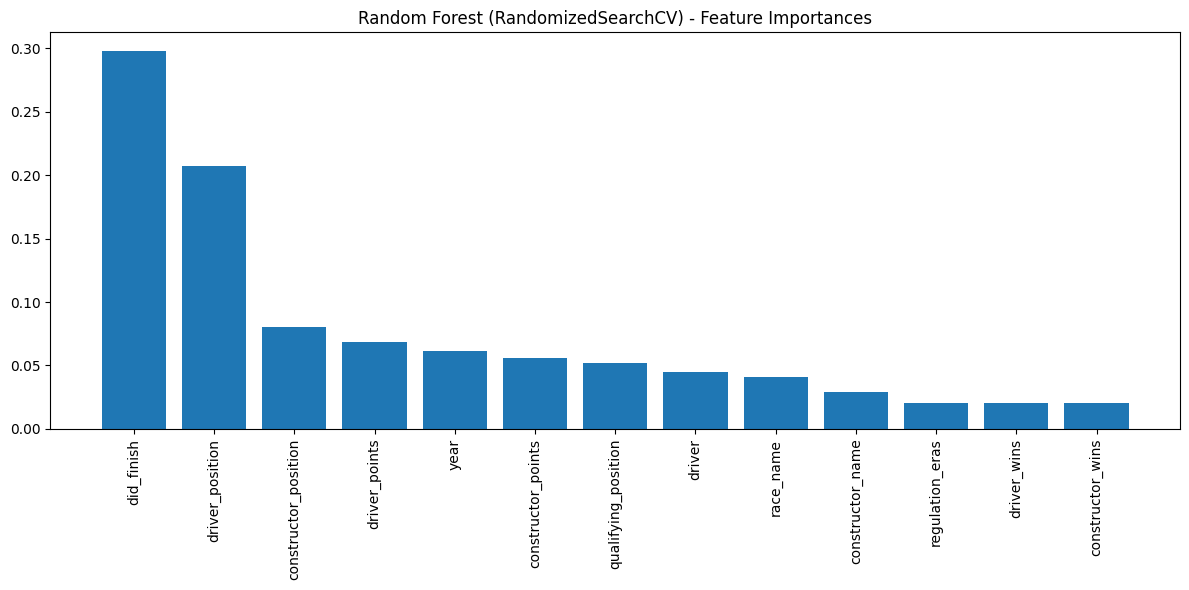

Plotting learning curve for Random Forest (RandomizedSearchCV)...


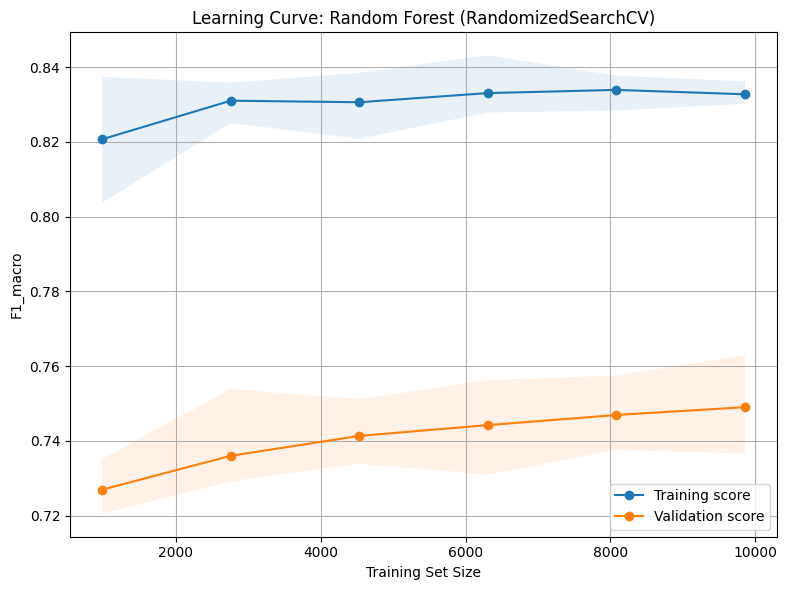

In [ ]:
# VALIDATION SET EVALUATION

#Get predictions on validation set
y_val_pred_rf_random = best_model_rf_random.predict(X_val_processed)

#Print Classification Report
print("\n" + "="*60)
print("RANDOM FOREST (RandomizedSearchCV) - VALIDATION RESULTS")
print("="*60)
print(f"Accuracy: {accuracy_score(y_val, y_val_pred_rf_random):.4f}")
print(f"F1-macro: {f1_score(y_val, y_val_pred_rf_random, labels=['Podium', 'Points', 'noPoints'], average='macro'):.4f}\n")
print("Classification Report:")
print(classification_report(y_val, y_val_pred_rf_random, labels=['Podium', 'Points', 'noPoints']))

#Plot Confusion Matrix
print("Plotting confusion matrix...")
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_estimator(
    best_model_rf_random,
    X_val_processed,
    y_val,
    labels=['Podium', 'Points', 'noPoints'],
    cmap='Blues',
    ax=ax
)
ax.set_title("Random Forest (RandomizedSearchCV) - Validation Confusion Matrix")
plt.tight_layout()
plt.show()

#Feature Importances
feature_names_num = numerical_features
feature_names_cat = list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))
all_feature_names = feature_names_num + feature_names_cat

importances_rf_random = best_model_rf_random.feature_importances_
indices_rf_random = np.argsort(importances_rf_random)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Random Forest (RandomizedSearchCV) - Feature Importances")
plt.bar(range(len(importances_rf_random)), importances_rf_random[indices_rf_random])
plt.xticks(range(len(importances_rf_random)), [all_feature_names[i] for i in indices_rf_random], rotation=90)
plt.tight_layout()
plt.show()

#Learning Curve
plot_learning_curve(
    estimator=best_model_rf_random,
    X=X_train_processed,
    y=y_train,
    cv=cv,
    scoring='f1_macro',
    model_name="Random Forest (RandomizedSearchCV)"
)


# SVM

## SVM OvO with RandomizedSearchCV

In [ ]:
#Build the OvO SVM pipeline
svm_pipeline_ovo_random = Pipeline([
    ('preprocessor', preprocessor),
    ('to_dense', FunctionTransformer(lambda x: x, accept_sparse=True)),
    ('classifier', OneVsOneClassifier(
        SVC(class_weight='balanced', probability=True, random_state=42)
    ))
])

#Define parameter distributions for RandomizedSearch
param_dist_ovo = {
    'classifier__estimator__C': loguniform(0.01, 100),  # logarithmic scale from 0.01 to 100
    'classifier__estimator__gamma': ['scale', 'auto'] + list(loguniform(1e-4, 1e-1).rvs(5, random_state=42)),  # scale/auto + 5 random values
    'classifier__estimator__kernel': ['rbf', 'linear']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#Run RandomizedSearchCV
print("Running RandomizedSearchCV for One-vs-One SVM...")
random_search_ovo = RandomizedSearchCV(
    estimator=svm_pipeline_ovo_random,
    param_distributions=param_dist_ovo,
    n_iter=12,
    cv=cv,
    scoring='f1_macro',
    verbose=2,
    n_jobs=-1,
    random_state=42
)

#Train
random_search_ovo.fit(X_train, y_train)

#Best model
best_model_ovo_random = random_search_ovo.best_estimator_
print("\n" + "="*60)
print("RandomizedSearchCV completed!")
print("="*60)
print(f"Best OvO SVM hyperparameters: {random_search_ovo.best_params_}")
print(f"Best CV F1-macro score: {random_search_ovo.best_score_:.4f}")



Running RandomizedSearchCV for One-vs-One SVM...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

RandomizedSearchCV completed!
Best OvO SVM hyperparameters: {'classifier__estimator__C': np.float64(8.471801418819979), 'classifier__estimator__gamma': np.float64(0.015702970884055395), 'classifier__estimator__kernel': 'rbf'}
Best CV F1-macro score: 0.7177



SVM OvO (RandomizedSearchCV) - VALIDATION RESULTS
Accuracy: 0.7711
F1-macro: 0.7288

Classification Report:
              precision    recall  f1-score   support

      Podium       0.69      0.90      0.78       393
      Points       0.66      0.46      0.54       901
    noPoints       0.83      0.90      0.86      1786

    accuracy                           0.77      3080
   macro avg       0.73      0.75      0.73      3080
weighted avg       0.76      0.77      0.76      3080

Plotting confusion matrix...


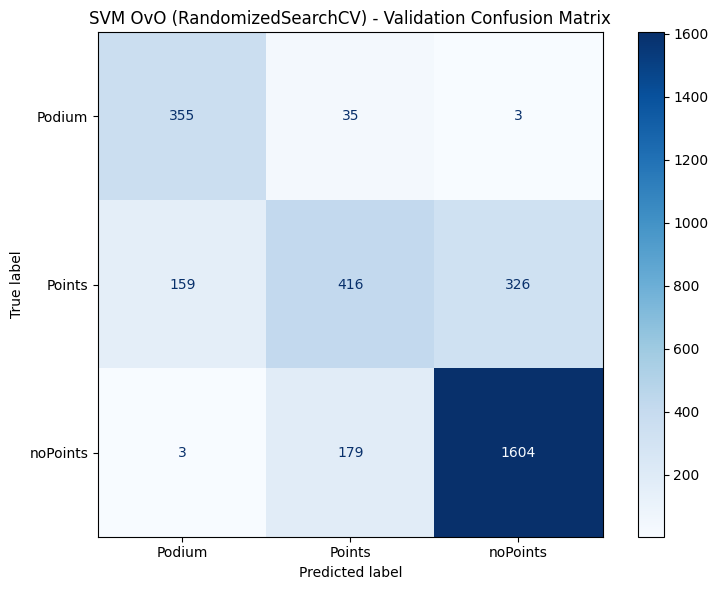

Plotting learning curve for SVM OvO (RandomizedSearchCV)...


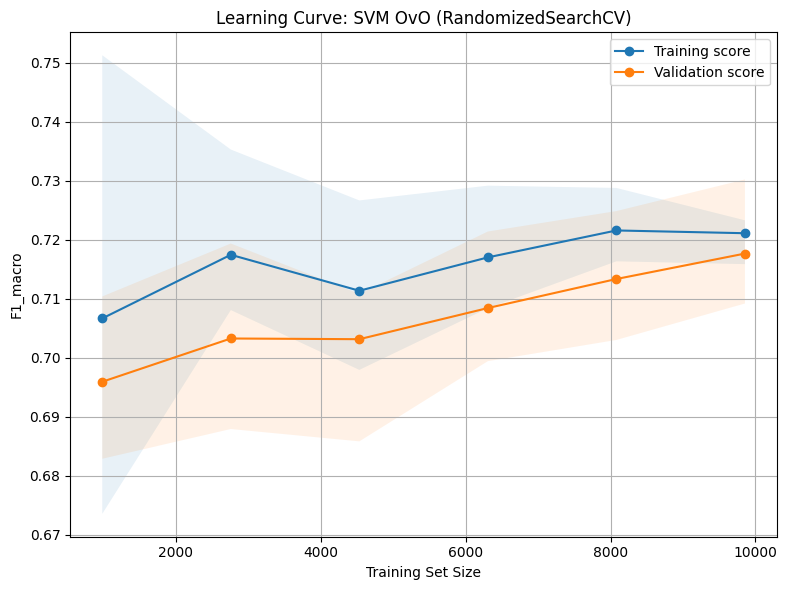


KERNEL ANALYSIS
RandomizedSearchCV best kernel: rbf

RandomizedSearchCV - Performance by kernel:
            mean       std       max
kernel                              
linear  0.687113  0.000814  0.688199
rbf     0.674653  0.033948  0.717675


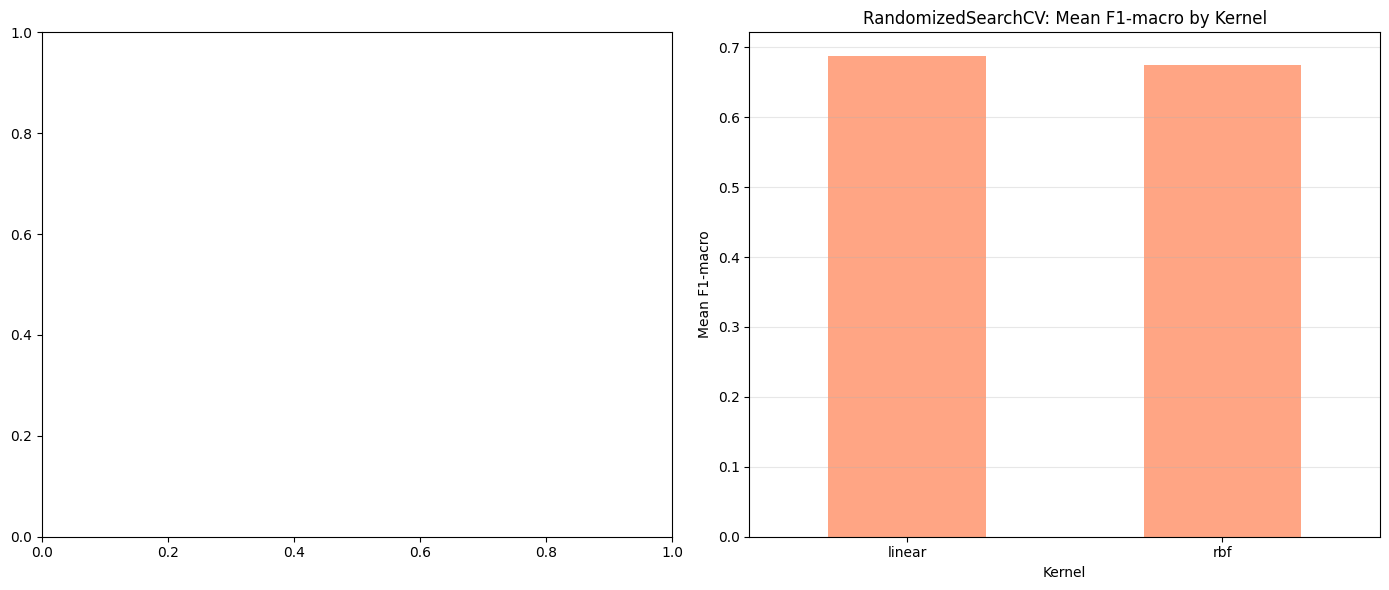

In [ ]:
#Predict on validation set
y_val_pred_ovo_random = best_model_ovo_random.predict(X_val)

#Print Classification Report
print("\n" + "="*60)
print("SVM OvO (RandomizedSearchCV) - VALIDATION RESULTS")
print("="*60)
print(f"Accuracy: {accuracy_score(y_val, y_val_pred_ovo_random):.4f}")
print(f"F1-macro: {f1_score(y_val, y_val_pred_ovo_random, labels=['Podium', 'Points', 'noPoints'], average='macro'):.4f}\n")
print("Classification Report:")
print(classification_report(y_val, y_val_pred_ovo_random, labels=['Podium', 'Points', 'noPoints']))

#Plot Confusion Matrix
print("Plotting confusion matrix...")
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_estimator(
    best_model_ovo_random,
    X_val,
    y_val,
    labels=['Podium', 'Points', 'noPoints'],
    cmap='Blues',
    ax=ax
)
ax.set_title("SVM OvO (RandomizedSearchCV) - Validation Confusion Matrix")
plt.tight_layout()
plt.show()

#Learning Curve
plot_learning_curve(
    estimator=best_model_ovo_random,
    X=X_train,
    y=y_train,
    cv=cv,
    scoring='f1_macro',
    model_name="SVM OvO (RandomizedSearchCV)"
)

# KERNEL COMPARISON (RBF vs Linear)

print("\n" + "="*70)
print("KERNEL ANALYSIS")
print("="*70)

# Extract best kernel
random_kernel = random_search_ovo.best_params_.get('classifier__estimator__kernel', 'N/A')

print(f"RandomizedSearchCV best kernel: {random_kernel}")

# Analyze RandomizedSearchCV results by kernel
cv_results_random = pd.DataFrame(random_search_ovo.cv_results_)
cv_results_random['kernel'] = cv_results_random['param_classifier__estimator__kernel']

kernel_performance_random = cv_results_random.groupby('kernel')['mean_test_score'].agg(['mean', 'std', 'max'])
print("\nRandomizedSearchCV - Performance by kernel:")
print(kernel_performance_random)

# Visualize kernel comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# RandomizedSearchCV kernel comparison
if len(kernel_performance_random) > 0:
    kernel_performance_random['mean'].plot(kind='bar', ax=axes[1], color='coral', alpha=0.7)
    axes[1].set_title('RandomizedSearchCV: Mean F1-macro by Kernel')
    axes[1].set_ylabel('Mean F1-macro')
    axes[1].set_xlabel('Kernel')
    axes[1].grid(axis='y', alpha=0.3)
    axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()


## SVM OvR with RandomizedSearchCV

In [ ]:
#OvR SVM pipeline
svm_pipeline_ovr_random = Pipeline([
    ('preprocessor', preprocessor),
    ('to_dense', FunctionTransformer(lambda x: x, accept_sparse=True)),
    ('classifier', SVC(
        decision_function_shape='ovr',
        class_weight='balanced',
        probability=True,
        random_state=42,
        max_iter=-1
    ))
])

#parameter distributions for RandomizedSearch
param_dist_ovr = {
    'classifier__C': loguniform(0.01, 100),  # logarithmic scale from 0.01 to 100
    'classifier__gamma': ['scale', 'auto'] + list(loguniform(1e-4, 1e-1).rvs(5, random_state=42)),  # scale/auto + 5 random values
    'classifier__kernel': ['rbf', 'linear']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#RandomizedSearchCV
print("Running RandomizedSearchCV for One-vs-Rest SVM...")
random_search_ovr = RandomizedSearchCV(
    estimator=svm_pipeline_ovr_random,
    param_distributions=param_dist_ovr,
    n_iter=12,  # 12 random combinations
    cv=cv,
    scoring='f1_macro',
    verbose=2,
    n_jobs=-1,
    random_state=42
)

#Train
random_search_ovr.fit(X_train, y_train)

best_model_ovr_random = random_search_ovr.best_estimator_
print("\n" + "="*60)
print("RandomizedSearchCV completed!")
print("="*60)
print(f"Best OvR SVM hyperparameters: {random_search_ovr.best_params_}")
print(f"Best CV F1-macro score: {random_search_ovr.best_score_:.4f}")


Running RandomizedSearchCV for One-vs-Rest SVM...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

RandomizedSearchCV completed!
Best OvR SVM hyperparameters: {'classifier__C': np.float64(8.471801418819979), 'classifier__gamma': np.float64(0.015702970884055395), 'classifier__kernel': 'rbf'}
Best CV F1-macro score: 0.7165



SVM OvR (RandomizedSearchCV) - VALIDATION RESULTS
Accuracy: 0.7708
F1-macro: 0.7273

Classification Report:
              precision    recall  f1-score   support

      Podium       0.68      0.90      0.78       393
      Points       0.66      0.46      0.54       901
    noPoints       0.83      0.90      0.86      1786

    accuracy                           0.77      3080
   macro avg       0.73      0.75      0.73      3080
weighted avg       0.76      0.77      0.76      3080

Plotting confusion matrix...


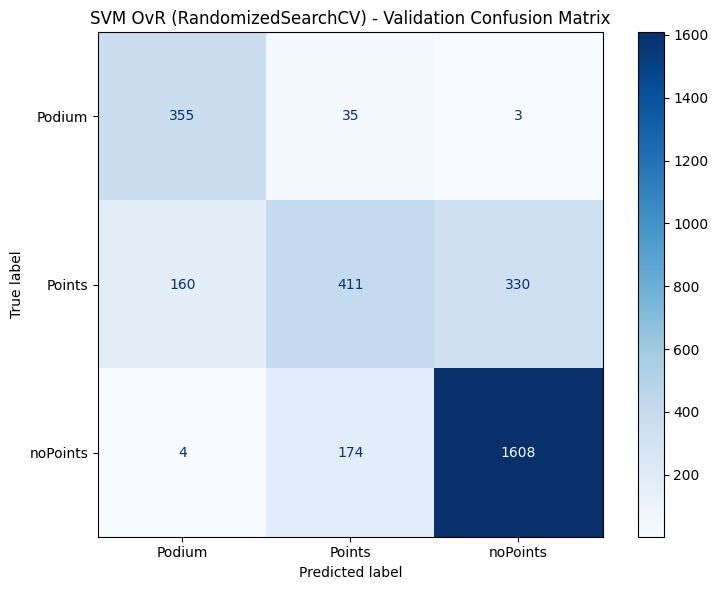

Plotting learning curve for SVM OvR (RandomizedSearchCV)...


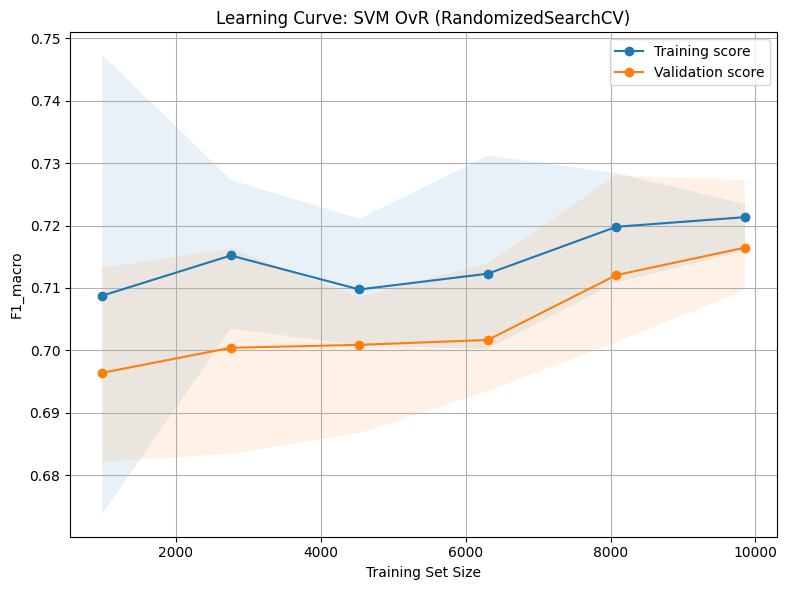


KERNEL ANALYSIS (OvR)
RandomizedSearchCV best kernel: rbf

RandomizedSearchCV - Performance by kernel:
            mean       std       max
kernel                              
linear  0.687399  0.000493  0.688042
rbf     0.674250  0.030009  0.716454


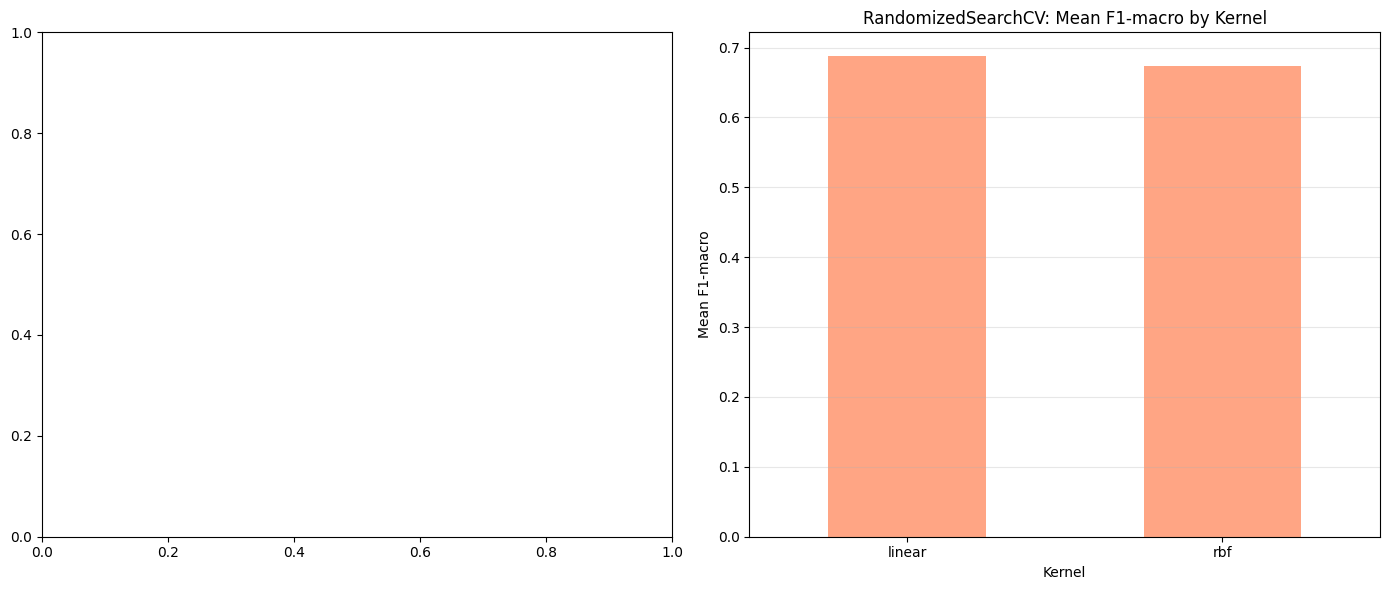


OvR vs OvO STRATEGY COMPARISON (RandomizedSearchCV)
   Strategy  Val_Accuracy  Val_F1_macro Best_Kernel  CV_F1_Score
One-vs-Rest      0.770779      0.727278         rbf     0.716454
 One-vs-One      0.771104      0.728751         rbf     0.717675


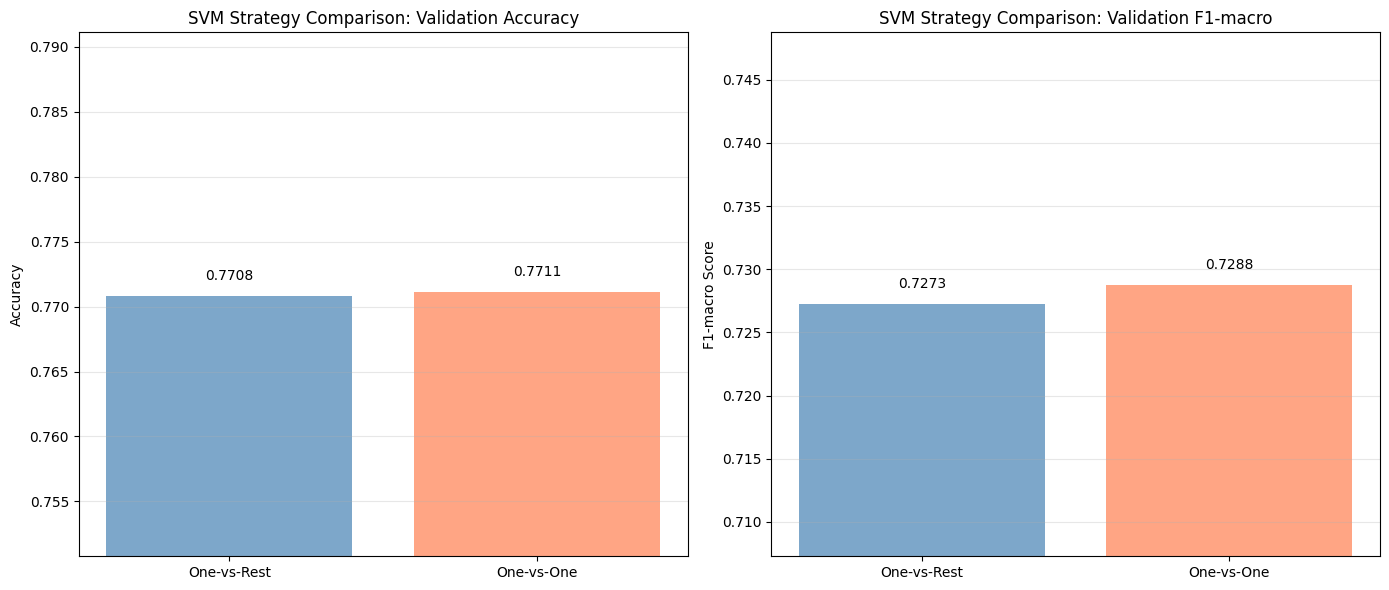

In [ ]:
# VALIDATION SET EVALUATION

#Predict on validation set
y_val_pred_ovr_random = best_model_ovr_random.predict(X_val)

print("\n" + "="*60)
print("SVM OvR (RandomizedSearchCV) - VALIDATION RESULTS")
print("="*60)
print(f"Accuracy: {accuracy_score(y_val, y_val_pred_ovr_random):.4f}")
print(f"F1-macro: {f1_score(y_val, y_val_pred_ovr_random, labels=['Podium', 'Points', 'noPoints'], average='macro'):.4f}\n")
print("Classification Report:")
print(classification_report(y_val, y_val_pred_ovr_random, labels=['Podium', 'Points', 'noPoints']))

#Plot Confusion Matrix
print("Plotting confusion matrix...")
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_estimator(
    best_model_ovr_random,
    X_val,
    y_val,
    labels=['Podium', 'Points', 'noPoints'],
    cmap='Blues',
    ax=ax
)
ax.set_title("SVM OvR (RandomizedSearchCV) - Validation Confusion Matrix")
plt.tight_layout()
plt.show()

#Learning Curve
plot_learning_curve(
    estimator=best_model_ovr_random,
    X=X_train,
    y=y_train,
    cv=cv,
    scoring='f1_macro',
    model_name="SVM OvR (RandomizedSearchCV)"
)

# KERNEL COMPARISON (RBF vs Linear)

print("\n" + "="*70)
print("KERNEL ANALYSIS (OvR)")
print("="*70)

# Extract best kernel from both searches
random_kernel = random_search_ovr.best_params_.get('classifier__kernel', 'N/A')

print(f"RandomizedSearchCV best kernel: {random_kernel}")

# Analyze RandomizedSearchCV results by kernel
cv_results_random = pd.DataFrame(random_search_ovr.cv_results_)
cv_results_random['kernel'] = cv_results_random['param_classifier__kernel']

kernel_performance_random = cv_results_random.groupby('kernel')['mean_test_score'].agg(['mean', 'std', 'max'])
print("\nRandomizedSearchCV - Performance by kernel:")
print(kernel_performance_random)

# Visualize kernel comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# RandomizedSearchCV kernel comparison
if len(kernel_performance_random) > 0:
    kernel_performance_random['mean'].plot(kind='bar', ax=axes[1], color='coral', alpha=0.7)
    axes[1].set_title('RandomizedSearchCV: Mean F1-macro by Kernel')
    axes[1].set_ylabel('Mean F1-macro')
    axes[1].set_xlabel('Kernel')
    axes[1].grid(axis='y', alpha=0.3)
    axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()


# ============================================
# OvR vs OvO STRATEGY COMPARISON
# ============================================

print("\n" + "="*70)
print("OvR vs OvO STRATEGY COMPARISON (RandomizedSearchCV)")
print("="*70)

strategy_comparison = pd.DataFrame({
    'Strategy': ['One-vs-Rest', 'One-vs-One'],
    'Val_Accuracy': [
        accuracy_score(y_val, y_val_pred_ovr_random),
        accuracy_score(y_val, y_val_pred_ovo_random)
    ],
    'Val_F1_macro': [
        f1_score(y_val, y_val_pred_ovr_random, labels=['Podium', 'Points', 'noPoints'], average='macro'),
        f1_score(y_val, y_val_pred_ovo_random, labels=['Podium', 'Points', 'noPoints'], average='macro')
    ],
    'Best_Kernel': [
        random_search_ovr.best_params_.get('classifier__kernel', 'N/A'),
        random_search_ovo.best_params_.get('classifier__estimator__kernel', 'N/A')
    ],
    'CV_F1_Score': [
        random_search_ovr.best_score_,
        random_search_ovo.best_score_
    ]
})

print(strategy_comparison.to_string(index=False))

# Visual comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

strategies = strategy_comparison['Strategy'].values
accuracies_strat = strategy_comparison['Val_Accuracy'].values
f1_scores_strat = strategy_comparison['Val_F1_macro'].values

# Accuracy comparison
axes[0].bar(strategies, accuracies_strat, color=['steelblue', 'coral'], alpha=0.7)
axes[0].set_ylabel('Accuracy')
axes[0].set_title('SVM Strategy Comparison: Validation Accuracy')
axes[0].set_ylim([min(accuracies_strat) - 0.02, max(accuracies_strat) + 0.02])
axes[0].grid(axis='y', alpha=0.3)

for i, v in enumerate(accuracies_strat):
    axes[0].text(i, v + 0.001, f'{v:.4f}', ha='center', va='bottom')

# F1-macro comparison
axes[1].bar(strategies, f1_scores_strat, color=['steelblue', 'coral'], alpha=0.7)
axes[1].set_ylabel('F1-macro Score')
axes[1].set_title('SVM Strategy Comparison: Validation F1-macro')
axes[1].set_ylim([min(f1_scores_strat) - 0.02, max(f1_scores_strat) + 0.02])
axes[1].grid(axis='y', alpha=0.3)

for i, v in enumerate(f1_scores_strat):
    axes[1].text(i, v + 0.001, f'{v:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Validation vs Test

In [ ]:


def evaluate_on_test(model, X_test_data, y_test_data, model_name, use_pipeline=False):
    """
    Evaluate a trained model on the test set.

    Parameters:
    - model: trained estimator
    - X_test_data: test features (raw DataFrame if use_pipeline=True, else preprocessed array)
    - y_test_data: true test labels
    - model_name: string name for titles
    - use_pipeline: True if model contains preprocessing (e.g., SVM pipelines)

    Returns:
    - acc: accuracy score
    - f1: macro F1-score
    - y_pred: predictions
    """
    print(f"\n{'='*60}")
    print(f"TEST SET EVALUATION: {model_name}")
    print(f"{'='*60}\n")

    # Predict
    y_pred = model.predict(X_test_data)

    # Metrics
    acc = accuracy_score(y_test_data, y_pred)
    f1 = f1_score(y_test_data, y_pred, labels=['Podium', 'Points', 'noPoints'], average='macro')

    print(f"Test Accuracy: {acc:.4f}")
    print(f"Test F1-macro:  {f1:.4f}\n")
    print("Classification Report:")
    print(classification_report(y_test_data, y_pred, labels=['Podium', 'Points', 'noPoints']))

    # Confusion Matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    ConfusionMatrixDisplay.from_estimator(
        model, X_test_data, y_test_data,
        labels=['Podium', 'Points', 'noPoints'],
        cmap='Greens',
        ax=ax
    )
    ax.set_title(f"{model_name} - Test Set Confusion Matrix")
    plt.tight_layout()
    plt.show()

    return acc, f1, y_pred

## Test set evaluation


EVALUATING ALL MODELS ON HELD-OUT TEST SET

TEST SET EVALUATION: Gaussian Naive Bayes

Test Accuracy: 0.7190
Test F1-macro:  0.6731

Classification Report:
              precision    recall  f1-score   support

      Podium       0.65      0.75      0.70       490
      Points       0.54      0.46      0.50      1127
    noPoints       0.81      0.84      0.83      2234

    accuracy                           0.72      3851
   macro avg       0.67      0.68      0.67      3851
weighted avg       0.71      0.72      0.71      3851



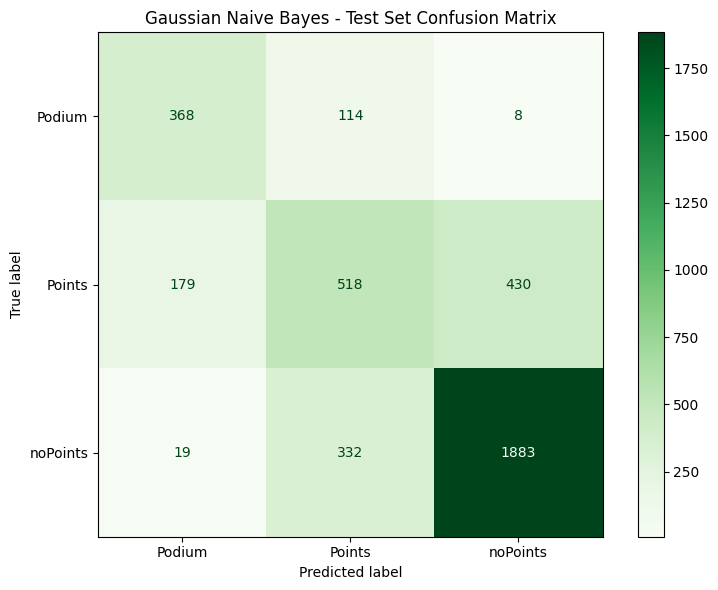


TEST SET EVALUATION: Softmax Regression

Test Accuracy: 0.7689
Test F1-macro:  0.7238

Classification Report:
              precision    recall  f1-score   support

      Podium       0.75      0.76      0.76       490
      Points       0.64      0.49      0.55      1127
    noPoints       0.82      0.91      0.86      2234

    accuracy                           0.77      3851
   macro avg       0.74      0.72      0.72      3851
weighted avg       0.76      0.77      0.76      3851



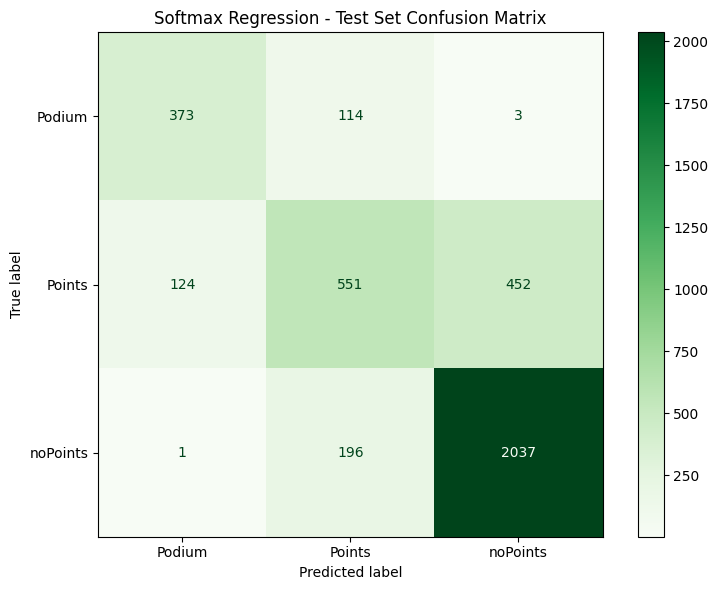


TEST SET EVALUATION: Decision Tree

Test Accuracy: 0.7886
Test F1-macro:  0.7305

Classification Report:
              precision    recall  f1-score   support

      Podium       0.76      0.75      0.75       490
      Points       0.74      0.45      0.56      1127
    noPoints       0.81      0.97      0.88      2234

    accuracy                           0.79      3851
   macro avg       0.77      0.72      0.73      3851
weighted avg       0.78      0.79      0.77      3851



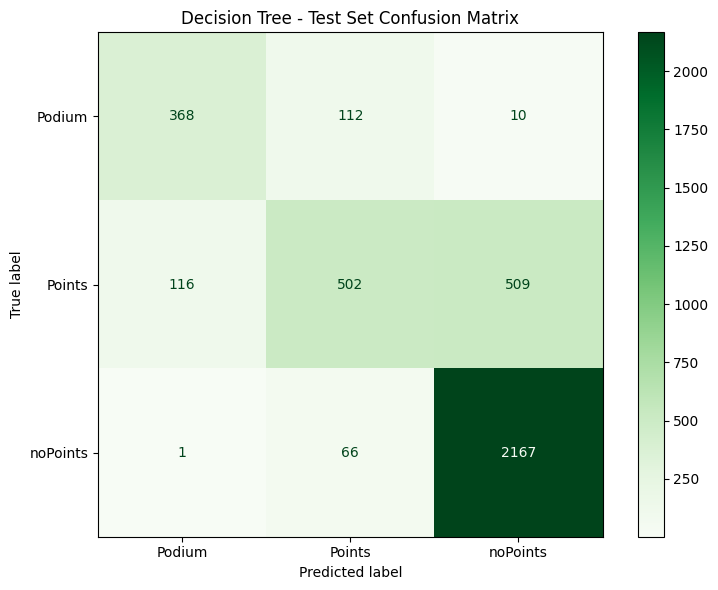


TEST SET EVALUATION: Random Forest

Test Accuracy: 0.8052
Test F1-macro:  0.7612

Classification Report:
              precision    recall  f1-score   support

      Podium       0.80      0.78      0.79       490
      Points       0.75      0.51      0.61      1127
    noPoints       0.82      0.96      0.89      2234

    accuracy                           0.81      3851
   macro avg       0.79      0.75      0.76      3851
weighted avg       0.80      0.81      0.79      3851



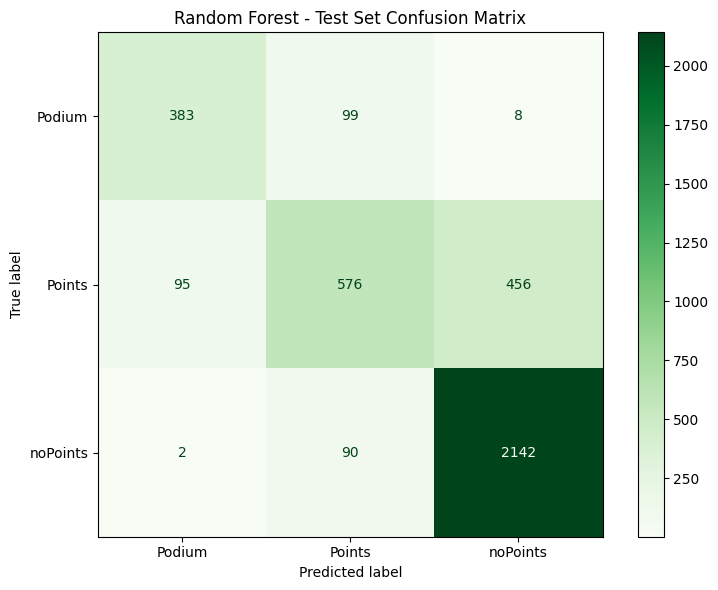


TEST SET EVALUATION: SVM (One-vs-Rest)

Test Accuracy: 0.7715
Test F1-macro:  0.7311

Classification Report:
              precision    recall  f1-score   support

      Podium       0.69      0.90      0.78       490
      Points       0.65      0.47      0.55      1127
    noPoints       0.83      0.89      0.86      2234

    accuracy                           0.77      3851
   macro avg       0.73      0.76      0.73      3851
weighted avg       0.76      0.77      0.76      3851



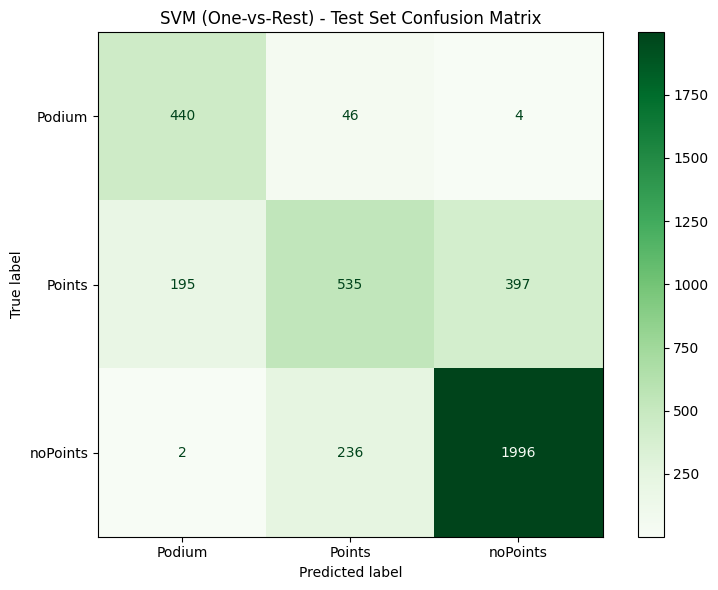


TEST SET EVALUATION: SVM (One-vs-One)

Test Accuracy: 0.7715
Test F1-macro:  0.7316

Classification Report:
              precision    recall  f1-score   support

      Podium       0.69      0.90      0.78       490
      Points       0.66      0.47      0.55      1127
    noPoints       0.83      0.89      0.86      2234

    accuracy                           0.77      3851
   macro avg       0.73      0.76      0.73      3851
weighted avg       0.76      0.77      0.76      3851



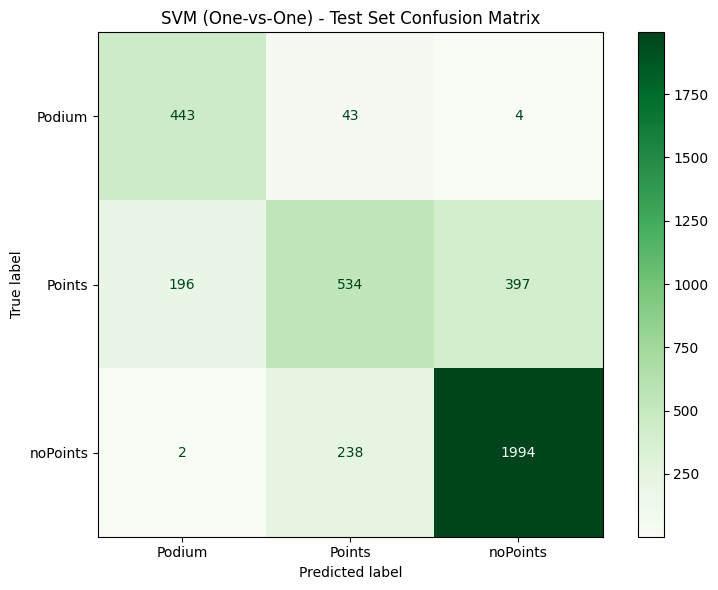


FINAL TEST METRICS SUMMARY
              Accuracy  F1_macro
RandomForest  0.805245  0.761231
SVM_OvO       0.771488  0.731617
SVM_OvR       0.771488  0.731087
DecisionTree  0.788626  0.730461
Softmax       0.768891  0.723809
GNB           0.719034  0.673070


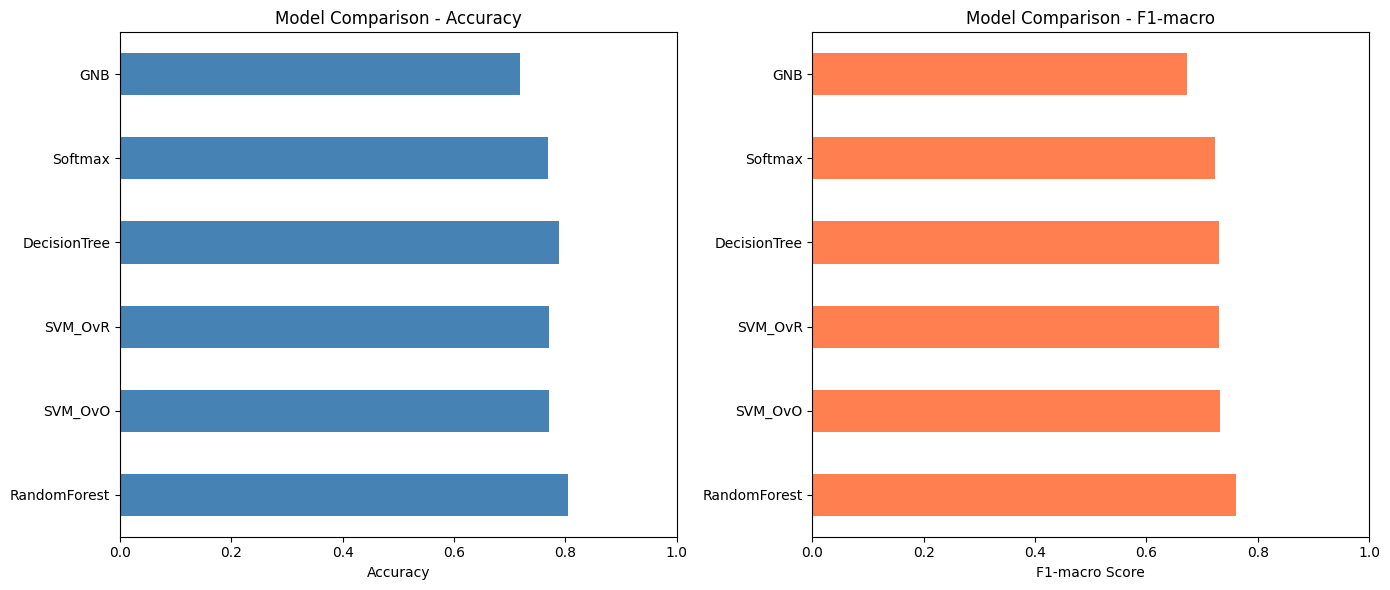


Best model by F1-macro: RandomForest (0.7612)


In [ ]:
print("\n" + "="*70)
print("EVALUATING ALL MODELS ON HELD-OUT TEST SET")
print("="*70)

# Store results
test_results = {
    'Accuracy': {},
    'F1_macro': {}
}

# 1. Gaussian Naive Bayes
acc_nb, f1_nb, _ = evaluate_on_test(
    model=model_NB,
    X_test_data=X_test_processed,
    y_test_data=y_test,
    model_name="Gaussian Naive Bayes"
)
test_results['Accuracy']['GNB'] = acc_nb
test_results['F1_macro']['GNB'] = f1_nb

# 2. Softmax Regression
acc_lr, f1_lr, _ = evaluate_on_test(
    model=best_model_lr_random,
    X_test_data=X_test_processed,
    y_test_data=y_test,
    model_name="Softmax Regression"
)
test_results['Accuracy']['Softmax'] = acc_lr
test_results['F1_macro']['Softmax'] = f1_lr

# 3. Decision Tree
acc_dt, f1_dt, _ = evaluate_on_test(
    model=best_model_dt_random,
    X_test_data=X_test_processed,
    y_test_data=y_test,
    model_name="Decision Tree"
)
test_results['Accuracy']['DecisionTree'] = acc_dt
test_results['F1_macro']['DecisionTree'] = f1_dt

# 4. Random Forest
acc_rf, f1_rf, _ = evaluate_on_test(
    model=best_model_rf_random,
    X_test_data=X_test_processed,
    y_test_data=y_test,
    model_name="Random Forest"
)
test_results['Accuracy']['RandomForest'] = acc_rf
test_results['F1_macro']['RandomForest'] = f1_rf

# 5. SVM OvR
acc_svm, f1_svm, _ = evaluate_on_test(
    model=best_model_ovr_random,
    X_test_data=X_test,
    y_test_data=y_test,
    model_name="SVM (One-vs-Rest)",
    use_pipeline=True
)
test_results['Accuracy']['SVM_OvR'] = acc_svm
test_results['F1_macro']['SVM_OvR'] = f1_svm

# 6. SVM OvO
acc_ovo, f1_ovo, _ = evaluate_on_test(
    model=best_model_ovo_random,
    X_test_data=X_test,
    y_test_data=y_test,
    model_name="SVM (One-vs-One)",
    use_pipeline=True
)
test_results['Accuracy']['SVM_OvO'] = acc_ovo
test_results['F1_macro']['SVM_OvO'] = f1_ovo

# ============================================
# Summary comparison
# ============================================
print("\n" + "="*70)
print("FINAL TEST METRICS SUMMARY")
print("="*70)

results_df = pd.DataFrame(test_results)
results_df = results_df.sort_values('F1_macro', ascending=False)
print(results_df)

# Side-by-side bar plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Accuracy comparison
results_df['Accuracy'].plot(kind='barh', ax=axes[0], color='steelblue')
axes[0].set_xlabel('Accuracy')
axes[0].set_title('Model Comparison - Accuracy')
axes[0].set_xlim([0, 1])

# F1-macro comparison
results_df['F1_macro'].plot(kind='barh', ax=axes[1], color='coral')
axes[1].set_xlabel('F1-macro Score')
axes[1].set_title('Model Comparison - F1-macro')
axes[1].set_xlim([0, 1])

plt.tight_layout()
plt.show()

# Highlight best model
best_model_f1 = results_df['F1_macro'].idxmax()
print(f"\nBest model by F1-macro: {best_model_f1} ({results_df.loc[best_model_f1, 'F1_macro']:.4f})")


VALIDATION vs TEST SET COMPARISON

              Validation_F1   Test_F1     Delta  Delta_pct
RandomForest       0.748333  0.761231  0.012899   1.723662
SVM_OvO            0.728751  0.731617  0.002866   0.393289
SVM_OvR            0.727278  0.731087  0.003809   0.523749
DecisionTree       0.731563  0.730461 -0.001102  -0.150695
Softmax            0.717074  0.723809  0.006735   0.939194
GNB                0.653207  0.673070  0.019863   3.040894


/tmp/ipython-input-4219946320.py:56: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend()


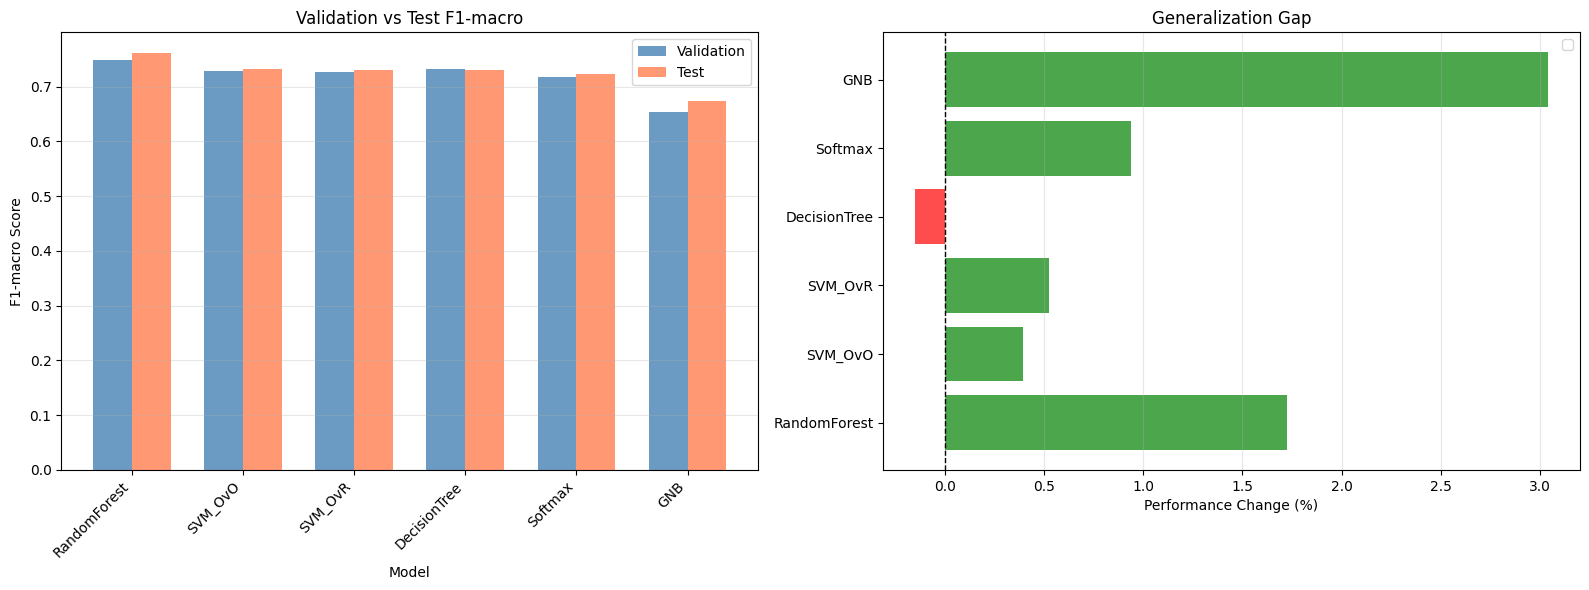

In [ ]:
# VALIDATION vs TEST COMPARISON
print("\n" + "="*70)
print("VALIDATION vs TEST SET COMPARISON")
print("="*70)

# Collect validation scores
val_results = {
    'GNB': f1_score(y_val, y_pred_nb_val, labels=['Podium', 'Points', 'noPoints'], average='macro'),
    'Softmax': f1_score(y_val, y_val_pred_lr_random, labels=['Podium', 'Points', 'noPoints'], average='macro'),
    'DecisionTree': f1_score(y_val, y_val_pred_dt_random, labels=['Podium', 'Points', 'noPoints'], average='macro'),
    'RandomForest': f1_score(y_val, y_val_pred_rf_random, labels=['Podium', 'Points', 'noPoints'], average='macro'),
    'SVM_OvR': f1_score(y_val, y_val_pred_ovr_random, labels=['Podium', 'Points', 'noPoints'], average='macro'),
    'SVM_OvO': f1_score(y_val, y_val_pred_ovo_random, labels=['Podium', 'Points', 'noPoints'], average='macro')
}

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Validation_F1': val_results,
    'Test_F1': test_results['F1_macro']
})

# Calculate difference (degradation if negative)
comparison_df['Delta'] = comparison_df['Test_F1'] - comparison_df['Validation_F1']
comparison_df['Delta_pct'] = (comparison_df['Delta'] / comparison_df['Validation_F1']) * 100

# Sort by test performance
comparison_df = comparison_df.sort_values('Test_F1', ascending=False)

print("\n" + comparison_df.to_string())


# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Side-by-side comparison
x = np.arange(len(comparison_df))
width = 0.35

axes[0].bar(x - width/2, comparison_df['Validation_F1'], width, label='Validation', color='steelblue', alpha=0.8)
axes[0].bar(x + width/2, comparison_df['Test_F1'], width, label='Test', color='coral', alpha=0.8)
axes[0].set_xlabel('Model')
axes[0].set_ylabel('F1-macro Score')
axes[0].set_title('Validation vs Test F1-macro')
axes[0].set_xticks(x)
axes[0].set_xticklabels(comparison_df.index, rotation=45, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# 2. Delta (generalization gap)
colors = ['green' if d >= 0 else 'red' for d in comparison_df['Delta']]
axes[1].barh(comparison_df.index, comparison_df['Delta_pct'], color=colors, alpha=0.7)
axes[1].set_xlabel('Performance Change (%)')
axes[1].set_title('Generalization Gap')
axes[1].axvline(0, color='black', linestyle='--', linewidth=1)
axes[1].grid(axis='x', alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()


# ROC CURVES AND AUC SCORES


GAUSSIAN NAIVE BAYES - ROC/AUC


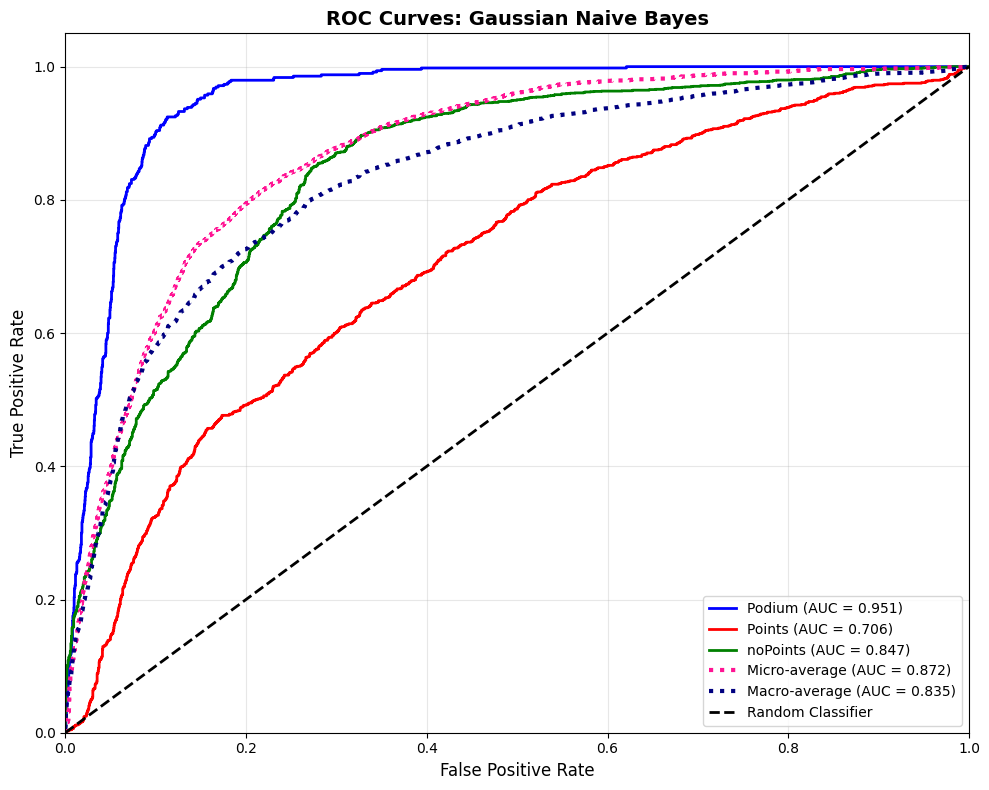


AUC Scores:
  Podium:  0.9513
  Points:  0.7065
  noPoints: 0.8469
  Macro-avg: 0.8351
  Micro-avg: 0.8720

SOFTMAX REGRESSION - ROC/AUC


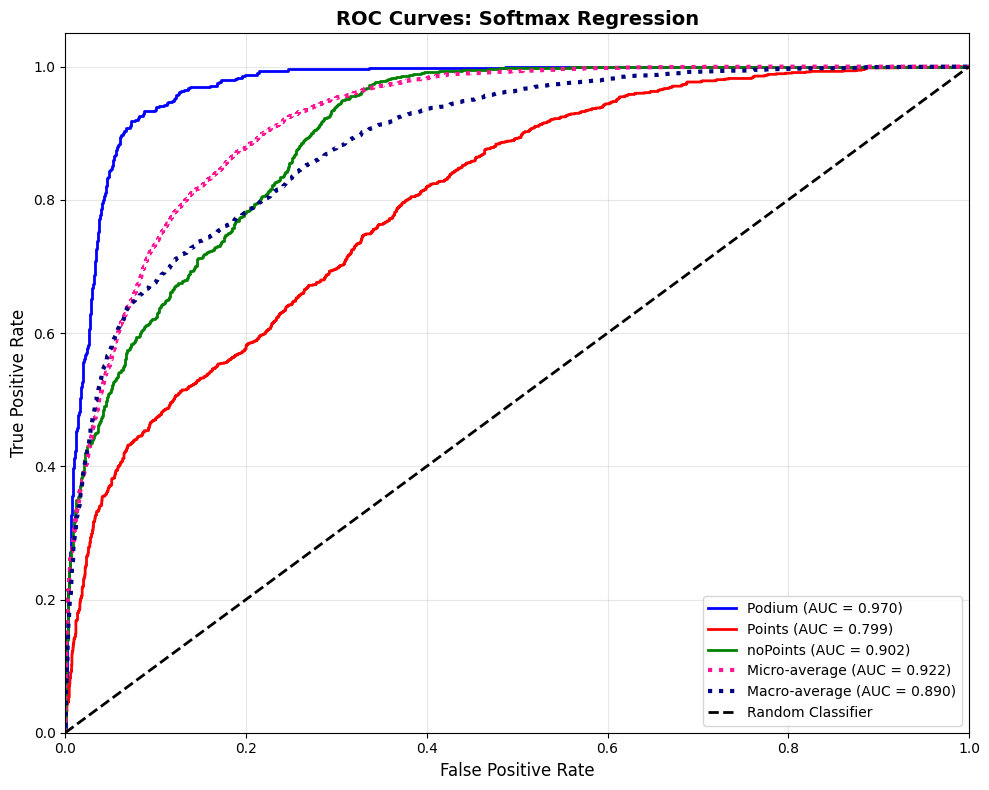


AUC Scores:
  Podium:  0.9696
  Points:  0.7988
  noPoints: 0.9015
  Macro-avg: 0.8902
  Micro-avg: 0.9221

DECISION TREE - ROC/AUC


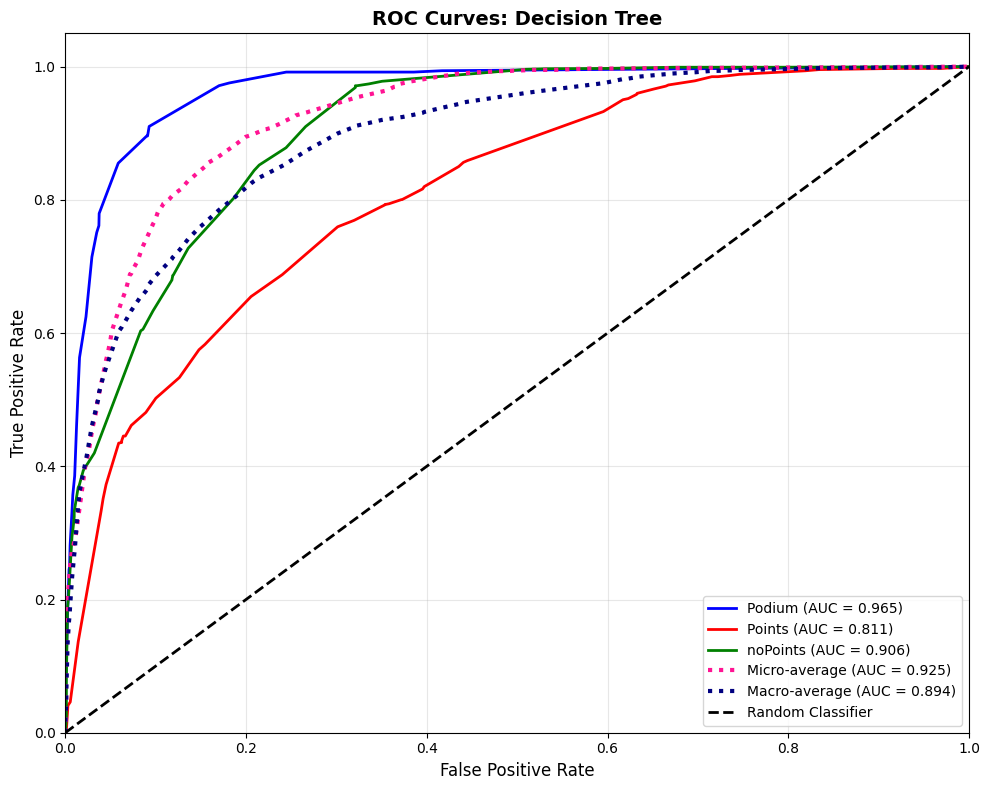


AUC Scores:
  Podium:  0.9652
  Points:  0.8112
  noPoints: 0.9061
  Macro-avg: 0.8942
  Micro-avg: 0.9254

RANDOM FOREST - ROC/AUC


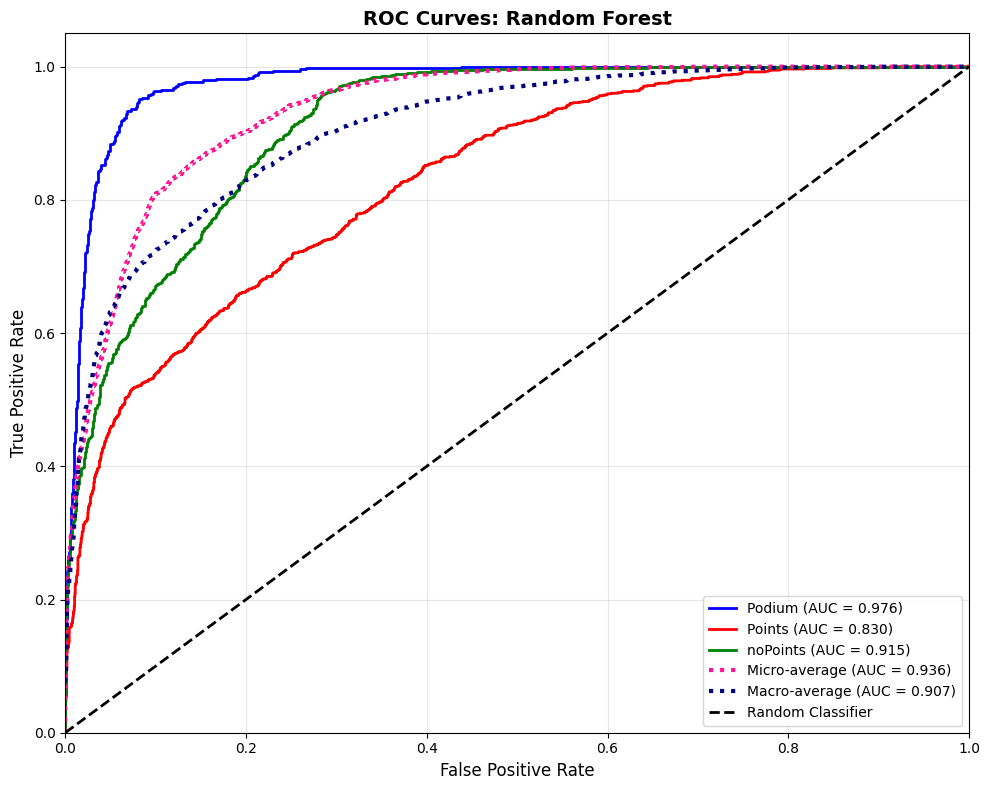


AUC Scores:
  Podium:  0.9759
  Points:  0.8299
  noPoints: 0.9146
  Macro-avg: 0.9070
  Micro-avg: 0.9356

SVM (One-vs-Rest) - ROC/AUC


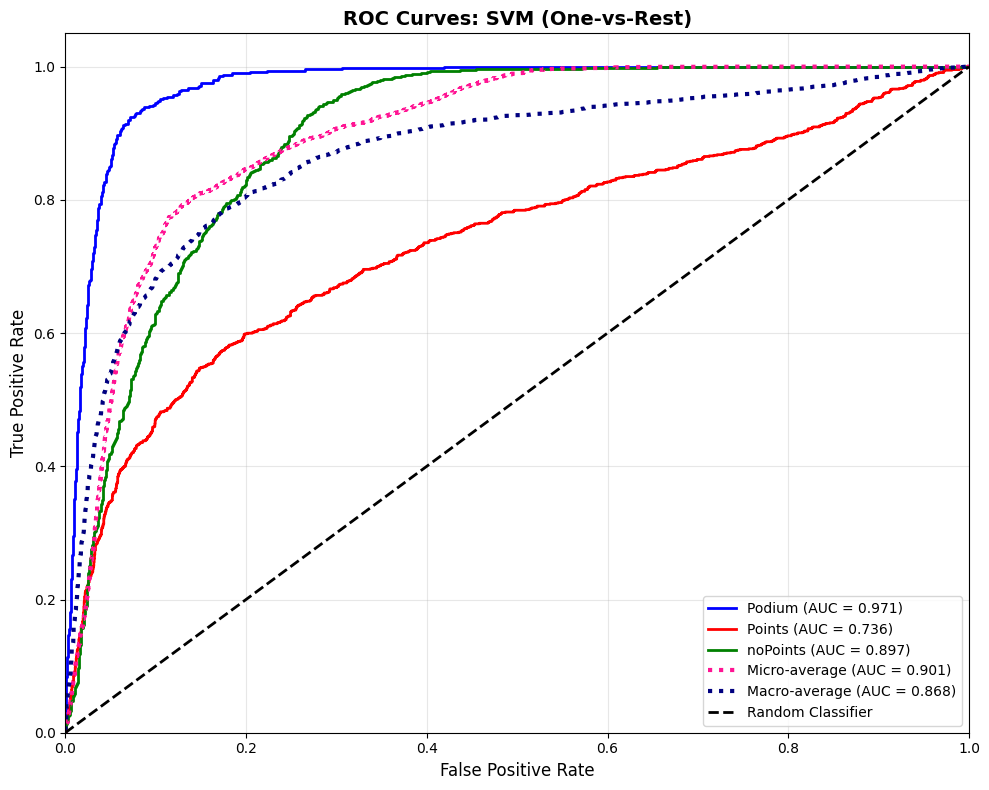


AUC Scores:
  Podium:  0.9711
  Points:  0.7363
  noPoints: 0.8967
  Macro-avg: 0.8683
  Micro-avg: 0.9006

SVM (One-vs-One) - ROC/AUC


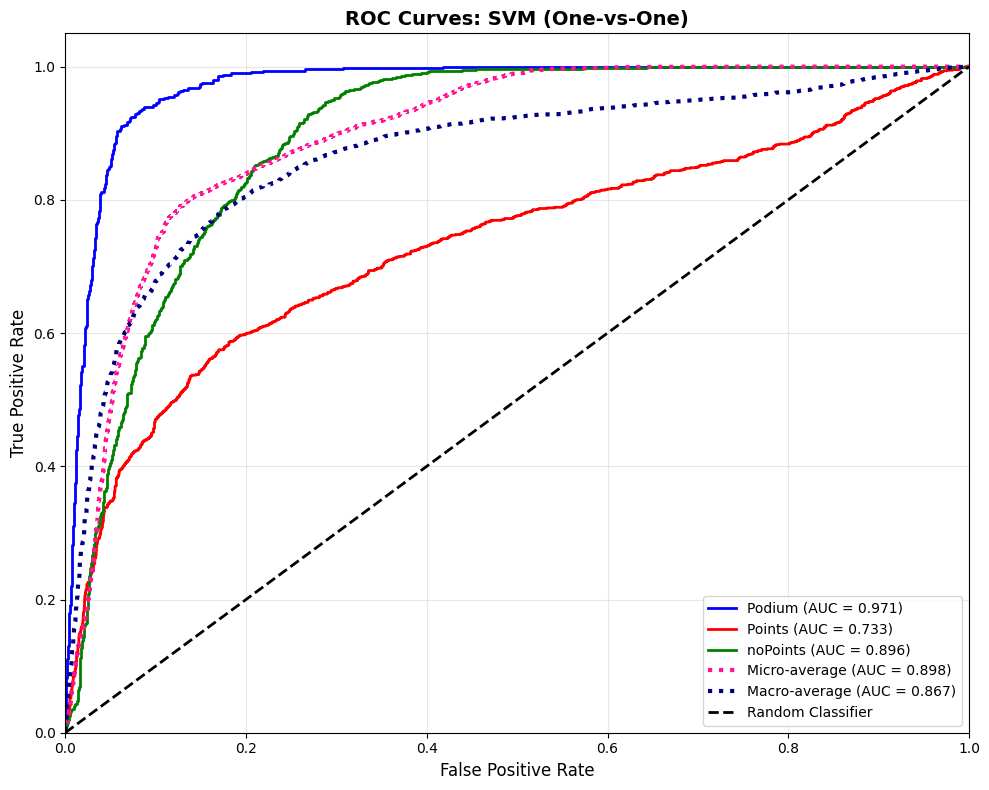


AUC Scores:
  Podium:  0.9710
  Points:  0.7327
  noPoints: 0.8960
  Macro-avg: 0.8668
  Micro-avg: 0.8982

AUC COMPARISON - ALL MODELS

       Model  Podium_AUC  Points_AUC  noPoints_AUC  Macro_AUC
RandomForest    0.975905    0.829933      0.914591   0.906993
DecisionTree    0.965183    0.811227      0.906094   0.894176
     Softmax    0.969633    0.798779      0.901535   0.890200
     SVM_OvR    0.971093    0.736345      0.896657   0.868263
     SVM_OvO    0.971037    0.732690      0.895980   0.866804
         GNB    0.951254    0.706465      0.846927   0.835105


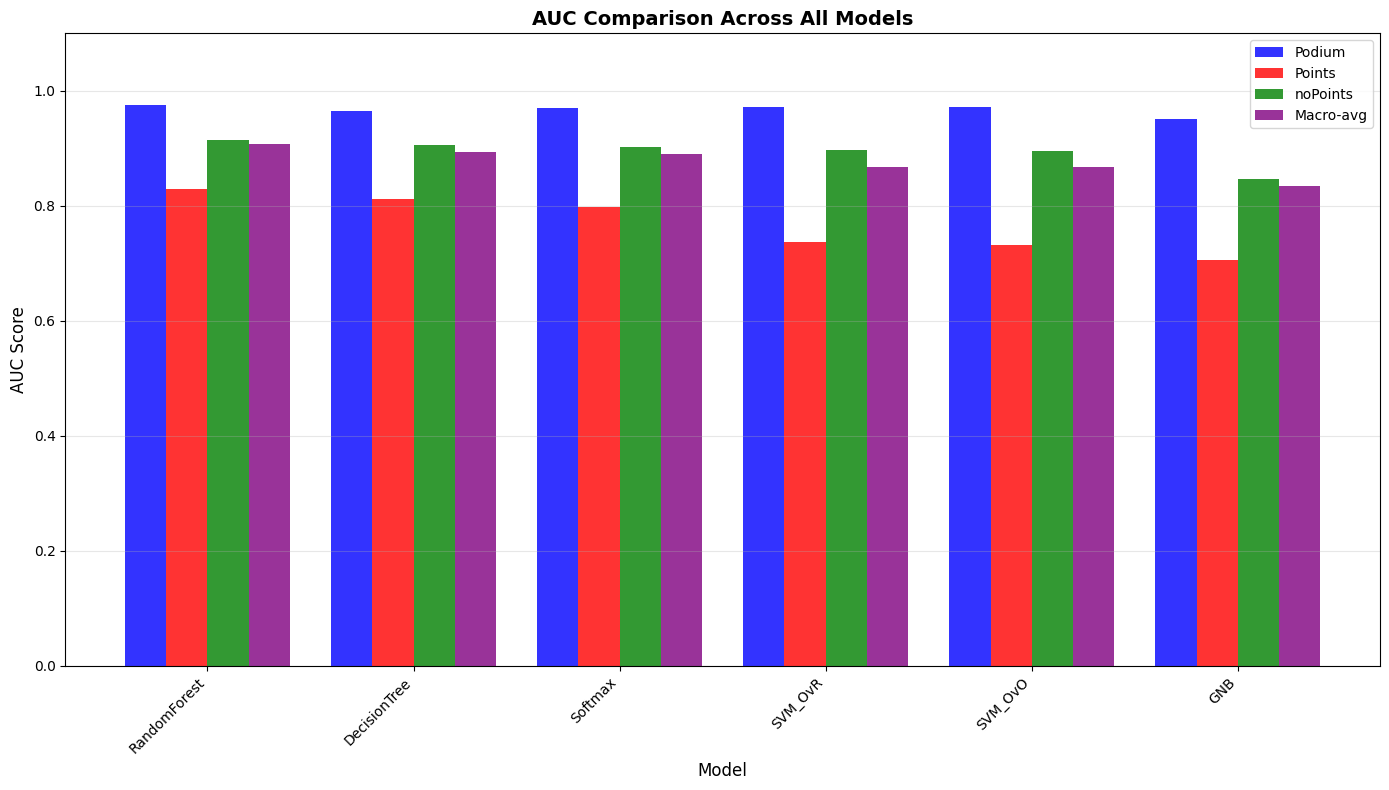


 Best model by Macro-AUC: RandomForest (0.9070)


In [ ]:
# Define class labels
classes = ['Podium', 'Points', 'noPoints']
n_classes = len(classes)

# Binarize the test labels for multi-class ROC
y_test_bin = label_binarize(y_test, classes=classes)

# Function to compute ROC curves and AUC

def plot_multiclass_roc(y_true_bin, y_score, model_name, classes):
    """
    Plot ROC curves for multi-class classification.

    Parameters:
    - y_true_bin: binarized true labels (n_samples, n_classes)
    - y_score: predicted probabilities (n_samples, n_classes)
    - model_name: string name for the plot title
    - classes: list of class names
    """
    n_classes = len(classes)

    # Compute ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and AUC
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and AUC
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot
    fig, ax = plt.subplots(figsize=(10, 8))

    # Plot ROC curve for each class
    colors = cycle(['blue', 'red', 'green'])
    for i, color in zip(range(n_classes), colors):
        ax.plot(
            fpr[i], tpr[i], color=color, lw=2,
            label=f'{classes[i]} (AUC = {roc_auc[i]:.3f})'
        )

    # Plot micro-average
    ax.plot(
        fpr["micro"], tpr["micro"],
        label=f'Micro-average (AUC = {roc_auc["micro"]:.3f})',
        color='deeppink', linestyle=':', linewidth=3
    )

    # Plot macro-average
    ax.plot(
        fpr["macro"], tpr["macro"],
        label=f'Macro-average (AUC = {roc_auc["macro"]:.3f})',
        color='navy', linestyle=':', linewidth=3
    )

    # Plot diagonal (random classifier)
    ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=12)
    ax.set_ylabel('True Positive Rate', fontsize=12)
    ax.set_title(f'ROC Curves: {model_name}', fontsize=14, fontweight='bold')
    ax.legend(loc="lower right", fontsize=10)
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    return roc_auc

# 1. GAUSSIAN NAIVE BAYES - ROC/AUC

print("\n" + "="*60)
print("GAUSSIAN NAIVE BAYES - ROC/AUC")
print("="*60)

# Get probability predictions
y_test_proba_nb = model_NB.predict_proba(X_test_processed)

# Plot ROC curves
roc_auc_nb = plot_multiclass_roc(y_test_bin, y_test_proba_nb, "Gaussian Naive Bayes", classes)

print(f"\nAUC Scores:")
print(f"  Podium:  {roc_auc_nb[0]:.4f}")
print(f"  Points:  {roc_auc_nb[1]:.4f}")
print(f"  noPoints: {roc_auc_nb[2]:.4f}")
print(f"  Macro-avg: {roc_auc_nb['macro']:.4f}")
print(f"  Micro-avg: {roc_auc_nb['micro']:.4f}")

# SOFTMAX REGRESSION - ROC/AUC

print("\n" + "="*60)
print("SOFTMAX REGRESSION - ROC/AUC")
print("="*60)

y_test_proba_lr = best_model_lr_random.predict_proba(X_test_processed)
roc_auc_lr = plot_multiclass_roc(y_test_bin, y_test_proba_lr, "Softmax Regression", classes)

print(f"\nAUC Scores:")
print(f"  Podium:  {roc_auc_lr[0]:.4f}")
print(f"  Points:  {roc_auc_lr[1]:.4f}")
print(f"  noPoints: {roc_auc_lr[2]:.4f}")
print(f"  Macro-avg: {roc_auc_lr['macro']:.4f}")
print(f"  Micro-avg: {roc_auc_lr['micro']:.4f}")


# DECISION TREE - ROC/AUC

print("\n" + "="*60)
print("DECISION TREE - ROC/AUC")
print("="*60)

y_test_proba_dt = best_model_dt_random.predict_proba(X_test_processed)
roc_auc_dt = plot_multiclass_roc(y_test_bin, y_test_proba_dt, "Decision Tree", classes)

print(f"\nAUC Scores:")
print(f"  Podium:  {roc_auc_dt[0]:.4f}")
print(f"  Points:  {roc_auc_dt[1]:.4f}")
print(f"  noPoints: {roc_auc_dt[2]:.4f}")
print(f"  Macro-avg: {roc_auc_dt['macro']:.4f}")
print(f"  Micro-avg: {roc_auc_dt['micro']:.4f}")

# RANDOM FOREST - ROC/AUC

print("\n" + "="*60)
print("RANDOM FOREST - ROC/AUC")
print("="*60)

y_test_proba_rf = best_model_rf_random.predict_proba(X_test_processed)
roc_auc_rf = plot_multiclass_roc(y_test_bin, y_test_proba_rf, "Random Forest", classes)

print(f"\nAUC Scores:")
print(f"  Podium:  {roc_auc_rf[0]:.4f}")
print(f"  Points:  {roc_auc_rf[1]:.4f}")
print(f"  noPoints: {roc_auc_rf[2]:.4f}")
print(f"  Macro-avg: {roc_auc_rf['macro']:.4f}")
print(f"  Micro-avg: {roc_auc_rf['micro']:.4f}")

# SVM OvR - ROC/AUC

print("\n" + "="*60)
print("SVM (One-vs-Rest) - ROC/AUC")
print("="*60)


y_test_decision_svm = best_model_ovr_random.decision_function(X_test)
y_test_proba_svm = softmax(y_test_decision_svm, axis=1)

roc_auc_svm = plot_multiclass_roc(y_test_bin, y_test_proba_svm, "SVM (One-vs-Rest)", classes)

print(f"\nAUC Scores:")
print(f"  Podium:  {roc_auc_svm[0]:.4f}")
print(f"  Points:  {roc_auc_svm[1]:.4f}")
print(f"  noPoints: {roc_auc_svm[2]:.4f}")
print(f"  Macro-avg: {roc_auc_svm['macro']:.4f}")
print(f"  Micro-avg: {roc_auc_svm['micro']:.4f}")

# SVM OvO - ROC/AUC

print("\n" + "="*60)
print("SVM (One-vs-One) - ROC/AUC")
print("="*60)

y_test_decision_ovo = best_model_ovo_random.decision_function(X_test)
y_test_proba_ovo = softmax(y_test_decision_ovo, axis=1)

roc_auc_ovo = plot_multiclass_roc(y_test_bin, y_test_proba_ovo, "SVM (One-vs-One)", classes)

print(f"\nAUC Scores:")
print(f"  Podium:  {roc_auc_ovo[0]:.4f}")
print(f"  Points:  {roc_auc_ovo[1]:.4f}")
print(f"  noPoints: {roc_auc_ovo[2]:.4f}")
print(f"  Macro-avg: {roc_auc_ovo['macro']:.4f}")
print(f"  Micro-avg: {roc_auc_ovo['micro']:.4f}")


# FINAL COMPARISON - AUC SCORES

print("\n" + "="*70)
print("AUC COMPARISON - ALL MODELS")
print("="*70)

auc_comparison = pd.DataFrame({
    'Model': ['GNB', 'Softmax', 'DecisionTree', 'RandomForest', 'SVM_OvR', 'SVM_OvO'],
    'Podium_AUC': [
        roc_auc_nb[0], roc_auc_lr[0], roc_auc_dt[0],
        roc_auc_rf[0], roc_auc_svm[0], roc_auc_ovo[0]
    ],
    'Points_AUC': [
        roc_auc_nb[1], roc_auc_lr[1], roc_auc_dt[1],
        roc_auc_rf[1], roc_auc_svm[1], roc_auc_ovo[1]
    ],
    'noPoints_AUC': [
        roc_auc_nb[2], roc_auc_lr[2], roc_auc_dt[2],
        roc_auc_rf[2], roc_auc_svm[2], roc_auc_ovo[2]
    ],
    'Macro_AUC': [
        roc_auc_nb['macro'], roc_auc_lr['macro'], roc_auc_dt['macro'],
        roc_auc_rf['macro'], roc_auc_svm['macro'], roc_auc_ovo['macro']
    ]
})

auc_comparison = auc_comparison.sort_values('Macro_AUC', ascending=False)
print("\n" + auc_comparison.to_string(index=False))

# Visualization
fig, ax = plt.subplots(figsize=(14, 8))

x = np.arange(len(auc_comparison))
width = 0.2

ax.bar(x - 1.5*width, auc_comparison['Podium_AUC'], width, label='Podium', alpha=0.8, color='blue')
ax.bar(x - 0.5*width, auc_comparison['Points_AUC'], width, label='Points', alpha=0.8, color='red')
ax.bar(x + 0.5*width, auc_comparison['noPoints_AUC'], width, label='noPoints', alpha=0.8, color='green')
ax.bar(x + 1.5*width, auc_comparison['Macro_AUC'], width, label='Macro-avg', alpha=0.8, color='purple')

ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('AUC Score', fontsize=12)
ax.set_title('AUC Comparison Across All Models', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(auc_comparison['Model'], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1.1])

plt.tight_layout()
plt.show()

# Best model by AUC
best_model_auc = auc_comparison.loc[auc_comparison['Macro_AUC'].idxmax(), 'Model']
best_auc_score = auc_comparison['Macro_AUC'].max()

print(f"\n Best model by Macro-AUC: {best_model_auc} ({best_auc_score:.4f})")


# Decision Boundaries


DECISION BOUNDARIES WITH PCA REDUCTION

Explained variance by 2 components: 71.46%
Component 1: 55.42%
Component 2: 16.04%

TRAINING MODELS ON 2D PCA DATA
✓ GNB trained on PCA data
✓ Softmax trained on PCA data
✓ Decision Tree trained on PCA data
✓ Random Forest trained on PCA data

PLOTTING DECISION BOUNDARIES

Plotting Gaussian Naive Bayes...


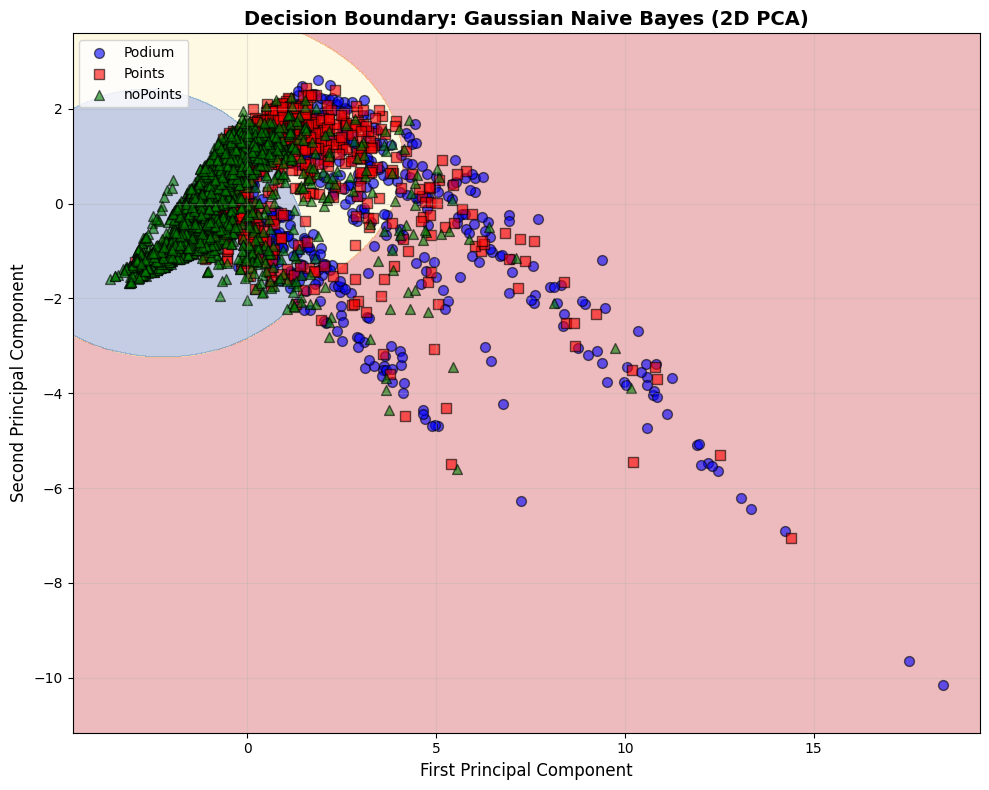


Plotting Softmax Regression...


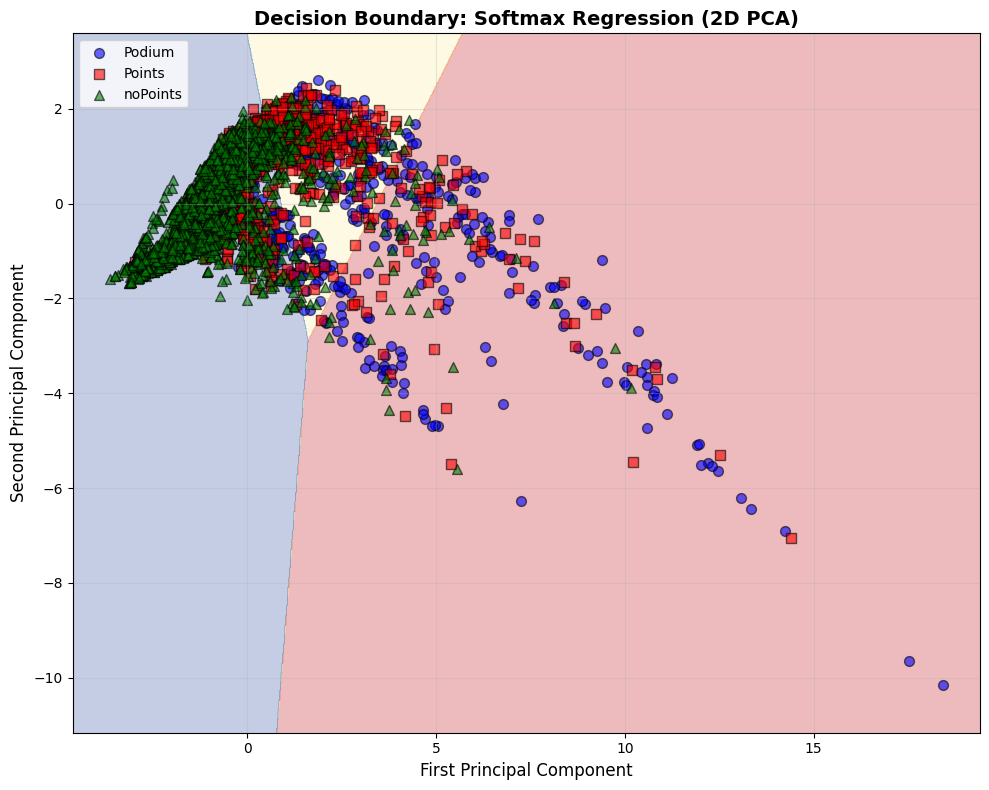


Plotting Decision Tree...


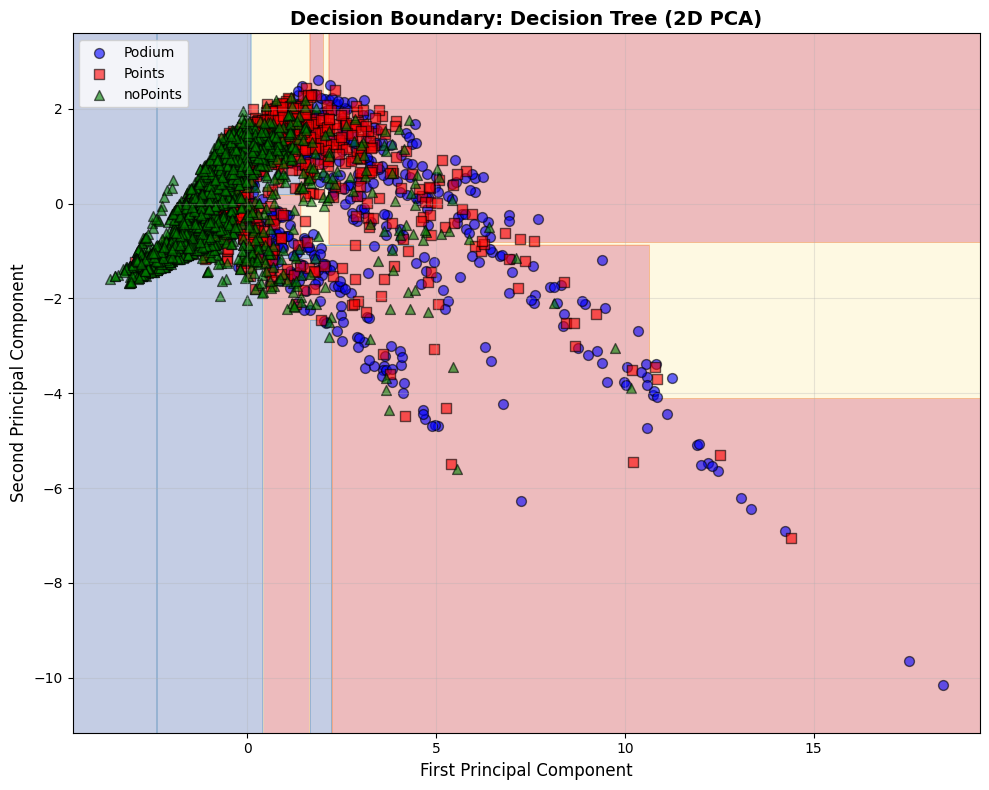


Plotting Random Forest...


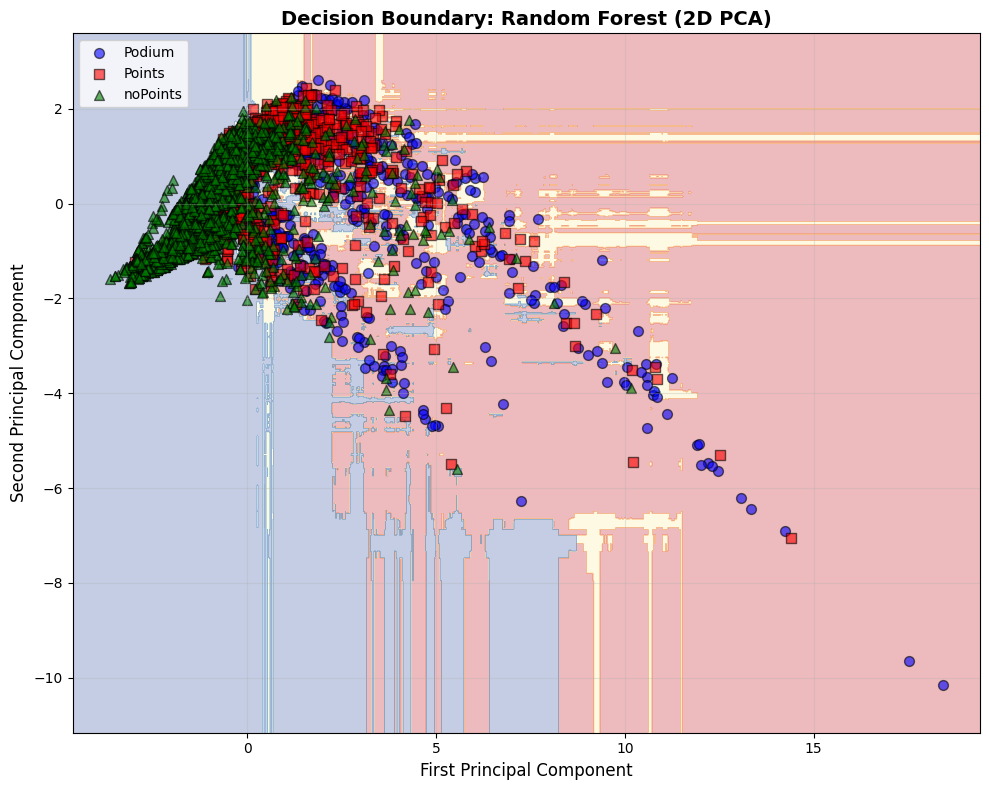


MODEL PERFORMANCE ON 2D PCA DATA
               Model  PCA_Accuracy  PCA_F1_macro  Original_F1_macro   F1_Drop
Gaussian Naive Bayes      0.665282      0.546942           0.673070 12.612784
  Softmax Regression      0.660608      0.532985           0.723809 19.082363
       Decision Tree      0.666320      0.589775           0.730461 14.068567
       Random Forest      0.653337      0.580508           0.761231 18.072339


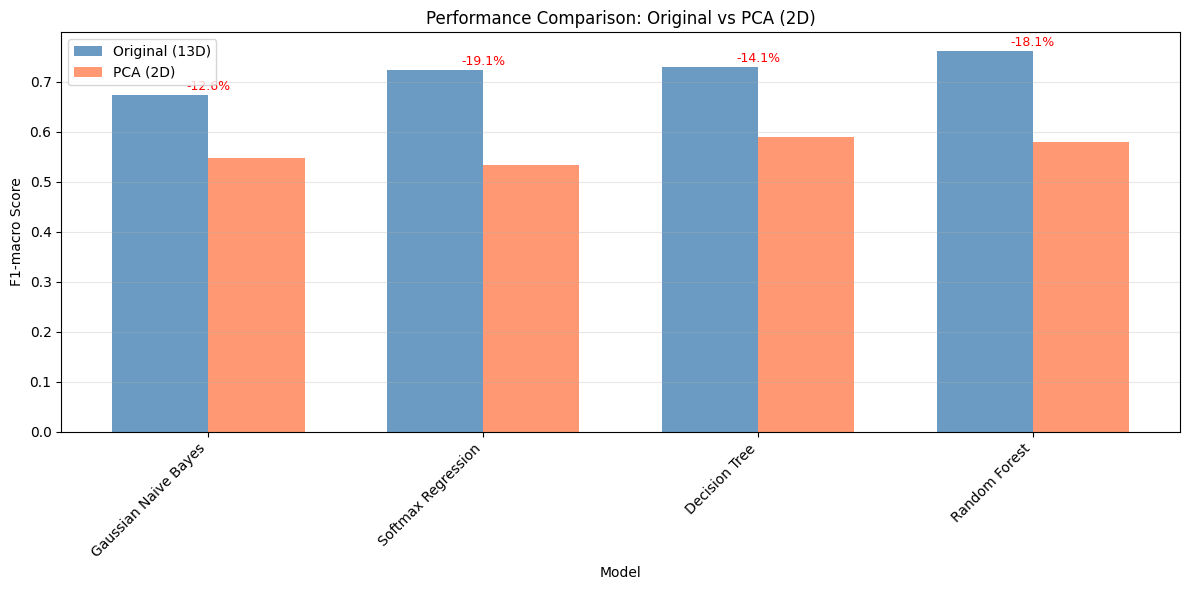

In [ ]:
# DECISION BOUNDARIES VISUALIZATION (2D PCA)

print("\n" + "="*70)
print("DECISION BOUNDARIES WITH PCA REDUCTION")
print("="*70)

# Reduce to 2D with PCA

pca = PCA(n_components=2, random_state=42)
X_train_pca = pca.fit_transform(X_train_processed)
X_test_pca = pca.transform(X_test_processed)

print(f"\nExplained variance by 2 components: {pca.explained_variance_ratio_.sum():.2%}")
print(f"Component 1: {pca.explained_variance_ratio_[0]:.2%}")
print(f"Component 2: {pca.explained_variance_ratio_[1]:.2%}")

# Function to plot decision boundaries


def plot_decision_boundary_2d(model, X, y, model_name, resolution=0.02):
    """
    Plot 2D decision boundary for a trained model.

    Parameters:
    - model: trained classifier
    - X: 2D feature array (n_samples, 2)
    - y: labels
    - model_name: string for title
    - resolution: mesh grid step size
    """
    # Setup marker generator and color map
    markers = ('o', 's', '^')
    colors = ('blue', 'red', 'green')
    cmap = plt.cm.RdYlBu

    # Plot decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    xx1, xx2 = np.meshgrid(
        np.arange(x1_min, x1_max, resolution),
        np.arange(x2_min, x2_max, resolution)
    )

    # Predict on mesh grid
    Z = model.predict(np.array([xx1.ravel(), xx2.ravel()]).T)

    # Map string labels to integers for plotting
    label_map = {'Podium': 0, 'Points': 1, 'noPoints': 2}
    Z_numeric = np.array([label_map[label] for label in Z])
    Z_numeric = Z_numeric.reshape(xx1.shape)

    # Plot
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.contourf(xx1, xx2, Z_numeric, alpha=0.3, cmap=cmap)
    ax.set_xlim(xx1.min(), xx1.max())
    ax.set_ylim(xx2.min(), xx2.max())

    # Plot samples
    y_numeric = np.array([label_map[label] for label in y])
    for idx, cl in enumerate(['Podium', 'Points', 'noPoints']):
        ax.scatter(
            x=X[y == cl, 0],
            y=X[y == cl, 1],
            alpha=0.6,
            c=colors[idx],
            marker=markers[idx],
            label=cl,
            edgecolor='black',
            s=50
        )

    ax.set_xlabel('First Principal Component', fontsize=12)
    ax.set_ylabel('Second Principal Component', fontsize=12)
    ax.set_title(f'Decision Boundary: {model_name} (2D PCA)', fontsize=14, fontweight='bold')
    ax.legend(loc='upper left')
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


# Models to Visualize

models_to_plot = {
    'Gaussian Naive Bayes': None,
    'Softmax Regression': None,
    'Decision Tree': None,
    'Random Forest': None,
}

# Train models on PCA-reduced data


print("\n" + "="*70)
print("TRAINING MODELS ON 2D PCA DATA")
print("="*70)

# Gaussian Naive Bayes
model_nb_pca = GaussianNB()
model_nb_pca.fit(X_train_pca, y_train)
models_to_plot['Gaussian Naive Bayes'] = model_nb_pca
print("✓ GNB trained on PCA data")

# Softmax Regression
model_lr_pca = LogisticRegression(C=best_model_lr_random.C, max_iter=5000, random_state=42)
model_lr_pca.fit(X_train_pca, y_train)
models_to_plot['Softmax Regression'] = model_lr_pca
print("✓ Softmax trained on PCA data")

# Decision Tree
model_dt_pca = DecisionTreeClassifier(
    max_depth=best_model_dt_random.max_depth,
    min_samples_split=best_model_dt_random.min_samples_split,
    random_state=42
)
model_dt_pca.fit(X_train_pca, y_train)
models_to_plot['Decision Tree'] = model_dt_pca
print("✓ Decision Tree trained on PCA data")

# Random Forest
model_rf_pca = RandomForestClassifier(
    n_estimators=best_model_rf_random.n_estimators,
    max_depth=best_model_rf_random.max_depth,
    random_state=42,
    n_jobs=-1
)
model_rf_pca.fit(X_train_pca, y_train)
models_to_plot['Random Forest'] = model_rf_pca
print("✓ Random Forest trained on PCA data")

# Plot Decision Boundaries

print("\n" + "="*70)
print("PLOTTING DECISION BOUNDARIES")
print("="*70)

for model_name, model in models_to_plot.items():
    print(f"\nPlotting {model_name}...")
    plot_decision_boundary_2d(model, X_test_pca, y_test, model_name)


# Performance on PCA Data


print("\n" + "="*70)
print("MODEL PERFORMANCE ON 2D PCA DATA")
print("="*70)



pca_results = []
for model_name, model in models_to_plot.items():
    y_pred_pca = model.predict(X_test_pca)
    acc = accuracy_score(y_test, y_pred_pca)
    f1 = f1_score(y_test, y_pred_pca, labels=['Podium', 'Points', 'noPoints'], average='macro')
    pca_results.append({
        'Model': model_name,
        'PCA_Accuracy': acc,
        'PCA_F1_macro': f1,
        'Original_F1_macro': test_results['F1_macro'].get(
            model_name.replace('Gaussian Naive Bayes', 'GNB')
                      .replace('Softmax Regression', 'Softmax')
                      .replace('Decision Tree', 'DecisionTree')
                      .replace('Random Forest', 'RandomForest')
        )
    })

pca_comparison_df = pd.DataFrame(pca_results)
pca_comparison_df['F1_Drop'] = (
    pca_comparison_df['Original_F1_macro'] - pca_comparison_df['PCA_F1_macro']
) * 100

print(pca_comparison_df.to_string(index=False))

# Visualization
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(pca_comparison_df))
width = 0.35

ax.bar(x - width/2, pca_comparison_df['Original_F1_macro'], width,
       label='Original (13D)', color='steelblue', alpha=0.8)
ax.bar(x + width/2, pca_comparison_df['PCA_F1_macro'], width,
       label='PCA (2D)', color='coral', alpha=0.8)

ax.set_xlabel('Model')
ax.set_ylabel('F1-macro Score')
ax.set_title('Performance Comparison: Original vs PCA (2D)')
ax.set_xticks(x)
ax.set_xticklabels(pca_comparison_df['Model'], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

for i, v in enumerate(pca_comparison_df['F1_Drop']):
    ax.text(i, max(pca_comparison_df['PCA_F1_macro'].iloc[i],
                   pca_comparison_df['Original_F1_macro'].iloc[i]) + 0.01,
            f'-{v:.1f}%', ha='center', fontsize=9, color='red')

plt.tight_layout()
plt.show()